In [1]:
import numpy as np
import pandas as pd
import utils
from pathlib import Path

In [2]:
from ipfx.feature_extractor import (SpikeFeatureExtractor, SpikeTrainFeatureExtractor)
import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps
from ipfx.data_set_features import extract_data_set_features
from ipfx.error import FeatureError

import os
import matplotlib.pyplot as plt

In [3]:
def plot_nwb_QC(nwb_path, ontology, stim_start_time, stim_end_time, baseline_interval=0.0001, subthresh_min_amp=-100.0, save_dir = None):
    data_set = create_ephys_data_set(nwb_file=nwb_path, ontology=ontology)  # loads nwb file into ipfx data structure
    cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
    long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
    long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
    long_square_sweeps = data_set.sweep_set()

    # Select epoch corresponding to the actual recording from the sweeps
    # and align sweeps so that the experiment would start at the same time
    long_square_sweeps.select_epoch("recording")

    # build the extractors
    spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
    sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval=baseline_interval)

    # run the analysis and print out a few of the features
    long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=subthresh_min_amp)
    lsa_results = long_square_analysis.analyze(long_square_sweeps) 
        
    rheobase_sweep_index = lsa_results['rheobase_sweep'].name
    final_sweep_index = long_square_sweeps.sweep_number[-1]
    
    sweeps_to_plot = [0, rheobase_sweep_index, final_sweep_index]
    
    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(12,8))
    fig.suptitle(f'{nwb_path}', fontsize=12)
    
    yticks = np.arange(min(data_set.sweep_set(0).sweeps[0].i), 
                       max(data_set.sweep_set(final_sweep_index).sweeps[0].i), 
                       100)
    
    for n, sweep in enumerate(sweeps_to_plot):
        curr_sweep = data_set.sweep_set(sweep).sweeps[0]
        t = curr_sweep.t
        v = curr_sweep.v
        i = curr_sweep.i
        
        if n == 2:
            axes[0].plot(t, v, alpha=0.5)
            axes[1].plot(t, i, alpha=0.5)
        else:
            axes[0].plot(t, v)
            axes[1].plot(t, i)

        axes[0].set_xlim(0, t[-1])
        axes[0].set_ylabel("Membrane voltage (mV)")
        axes[0].set_title(f'Rheo index: {rheobase_sweep_index} \n n_sweeps: {len(long_square_sweeps.sweep_number)}')

        axes[1].sharex(axes[0])
        axes[1].set_yticks(yticks)
        axes[1].set_ylabel("Injected current (pA)")
        axes[1].set_xlabel("Time (s)")        
    
    sweeps_df = lsa_results['sweeps']
    axes[2].plot(sweeps_df['stim_amp'], sweeps_df['avg_rate'], '.-')
    axes[2].set_ylabel("Average firing rate (Hz)")
    axes[2].set_xlabel("Stimulus amplitude (pA)")
    
    plt.tight_layout()
    
    if save_dir:
        file_stem = Path(nwb_path).stem
        plot_path = Path(save_dir) / f'{file_stem}.png'
        fig.savefig(plot_path, facecolor='w')    

In [4]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

natcom_path = Path('./data/processed/recordings/human/natcomm/')
h19_path = Path('./data/processed/recordings/human/h2019/')
h18_path = Path('./data/processed/recordings/human/h2018/')
m19_path = Path('./data/processed/recordings/mouse/m2019/')
m18_path = Path('./data/processed/recordings/mouse/m2018/')

h19 = utils.summary_df(path=h19_path, suffix='.nwb')
h18 = utils.summary_df(path=h18_path, suffix='.nwb')
m19 = utils.summary_df(path=m19_path, suffix='.nwb')
m18 = utils.summary_df(path=m18_path, suffix='.nwb')
natcom = utils.summary_df(path=natcom_path, suffix='.nwb')

h19['file_id'] = h19.file_name.str.rstrip('.nwb')
h18['file_id'] = h18.file_name.str.rstrip('.nwb')
m19['file_id'] = m19.file_name.str.rstrip('.nwb')
m18['file_id'] = m18.file_name.str.rstrip('.nwb')
natcom['file_id'] = natcom.file_name.str.rstrip('.nwb')

In [5]:
meta_h19 = pd.read_csv('./data/processed/meta/h2019_meta.csv', index_col=0).drop('path', axis=1)
meta_h18 = pd.read_csv('./data/processed/meta/h2018_meta.csv', index_col=0).drop('path', axis=1)
meta_m19 = pd.read_csv('./data/processed/meta/m2019_meta.csv', index_col=0).drop('path', axis=1)
meta_m18 = pd.read_csv('./data/processed/meta/m2018_meta.csv', index_col=0).drop('path', axis=1)

nat_com_meta_url = 'https://raw.githubusercontent.com/stripathy/valiante_lab_abf_process/master/output_files/cell_final_raw_meta_df.csv'
meta_natcom = pd.read_csv(nat_com_meta_url, index_col=0)
meta_natcom['file_id'] = meta_natcom.cell_id.apply(lambda x: x.rstrip('.abf'))

In [6]:
h19 = h19.merge(meta_h19.drop('file_name', axis=1), on='file_id')
h18 = h18.merge(meta_h18.drop('file_name', axis=1), on='file_id')
m19 = m19.merge(meta_m19.drop('file_name', axis=1), on='file_id')
m18 = m18.merge(meta_m18.drop('file_name', axis=1), on='file_id')
natcom = natcom.merge(meta_natcom, on='file_id')

In [7]:
h19_figs = Path('./data/processed/qc_figs/h19')
h19_figs.mkdir(exist_ok=True, parents=True)
h18_figs = Path('./data/processed/qc_figs/h18')
h18_figs.mkdir(exist_ok=True, parents=True)
m19_figs = Path('./data/processed/qc_figs/m19')
m19_figs.mkdir(exist_ok=True, parents=True)
m18_figs = Path('./data/processed/qc_figs/m18')
m18_figs.mkdir(exist_ok=True, parents=True)
natcom_figs = Path('./data/processed/qc_figs/natcom')
natcom_figs.mkdir(exist_ok=True, parents=True)

In [8]:
h19.loc[h19.file_name == '2019_11_26_0094.nwb', ['file_name', 'stim_start_time', 'stim_end_time']]

file_name  stim_start_time  stim_end_time
17  2019_11_26_0094.nwb           0.0921        0.69205

In [9]:
h19.loc[h19.file_name == '19o10010.nwb', ['file_name', 'stim_start_time', 'stim_end_time']]

file_name  stim_start_time  stim_end_time
41  19o10010.nwb           0.0921        0.69205

In [10]:
m19.loc[m19.file_name == '19o23039.nwb', ['file_name', 'stim_start_time', 'stim_end_time']]

file_name  stim_start_time  stim_end_time
3  19o23039.nwb           0.0921        0.69205

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate t

INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:----------------------------

INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interv

Error: The number of func parameters=3 must not exceed the number of data points=2 



INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
IN

INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
<ipython-input-3-7ddaee6cd842>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(3, 1, sharex=False, figsize=(12,8))
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find 

INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: *

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------

INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:-------------------------------------------------------

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculat

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
IN

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephys

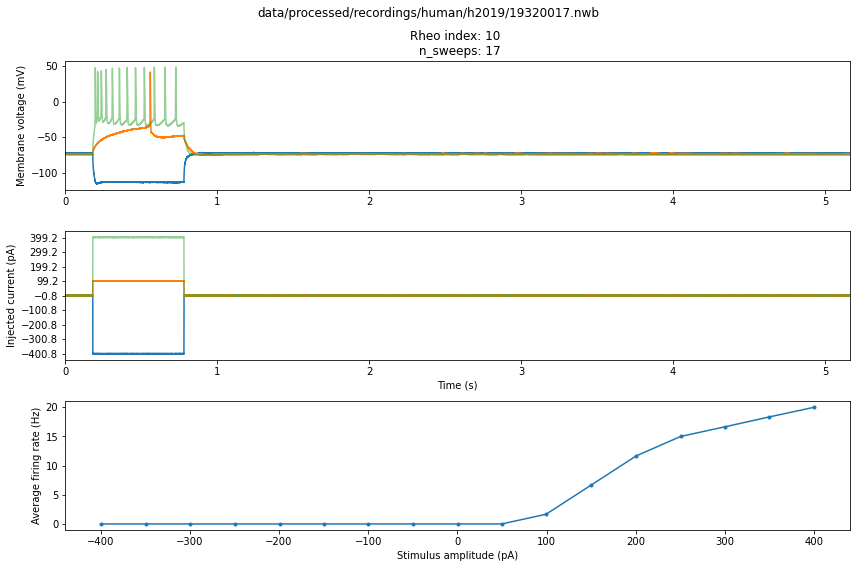

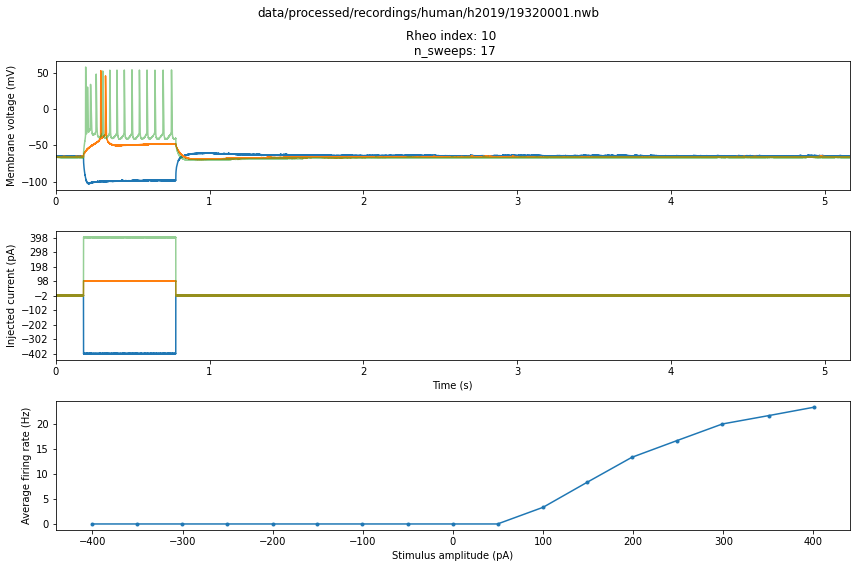

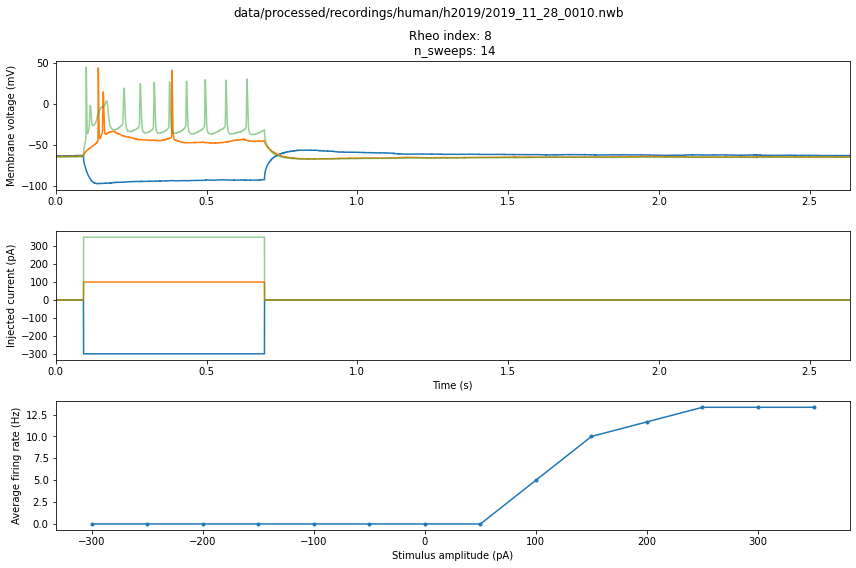

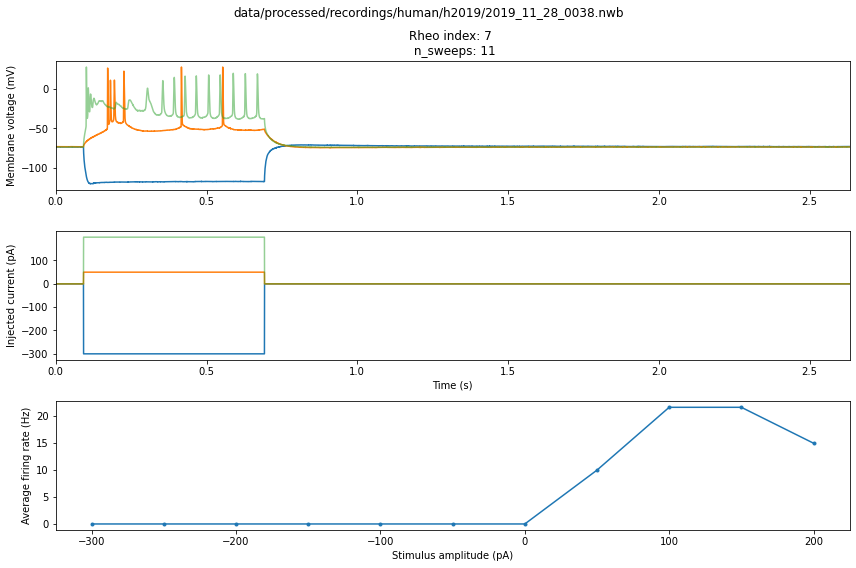

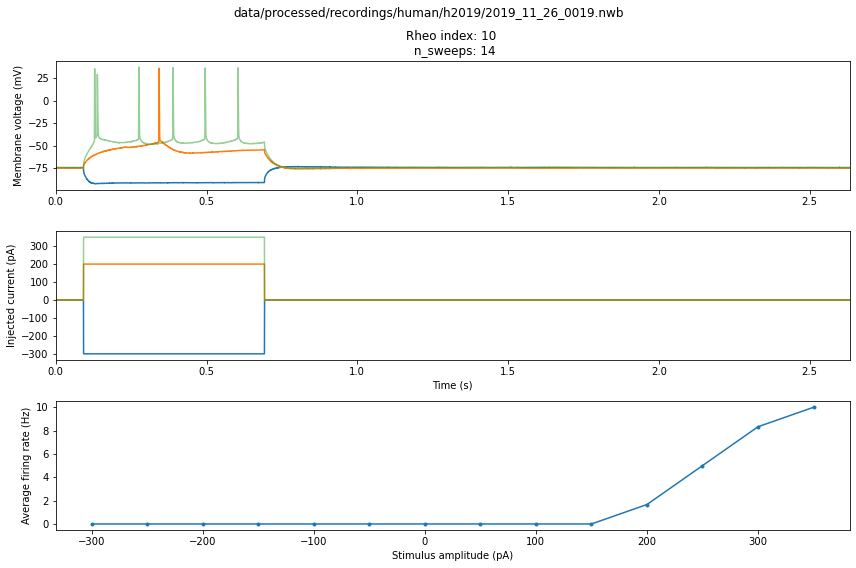

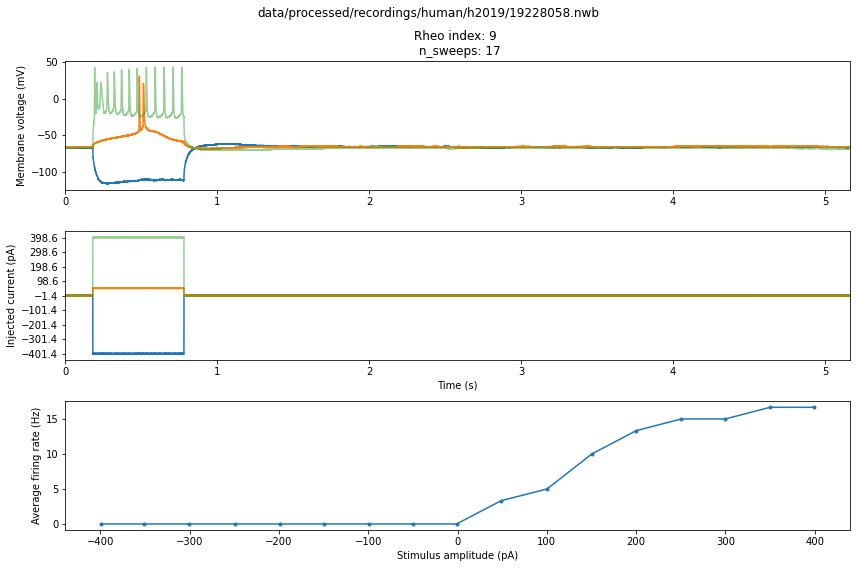

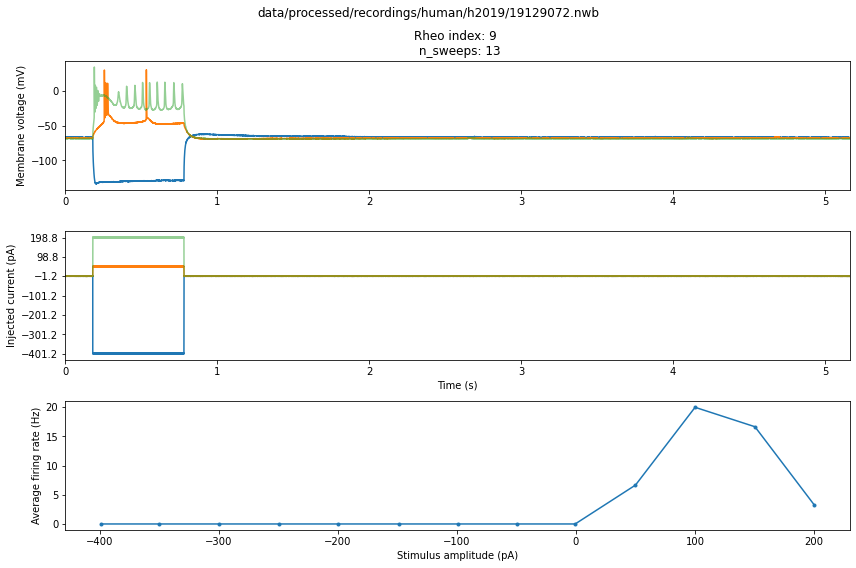

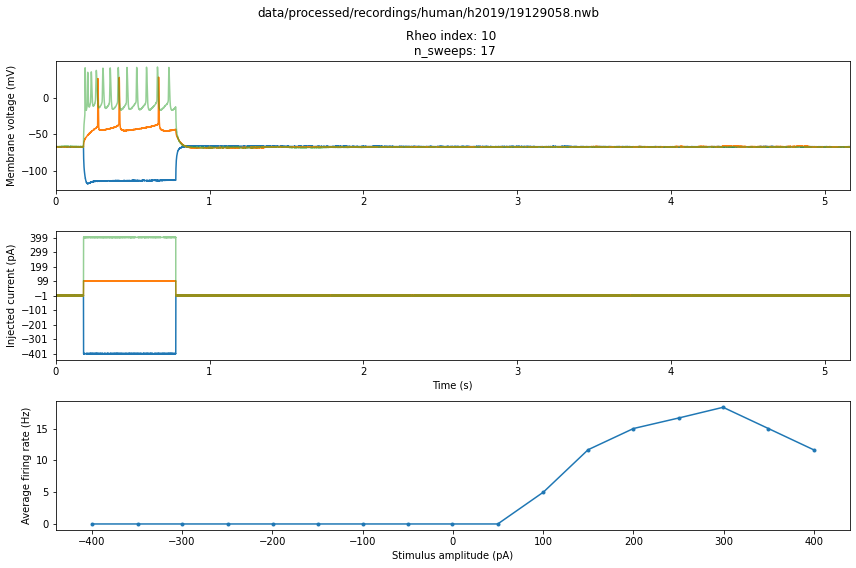

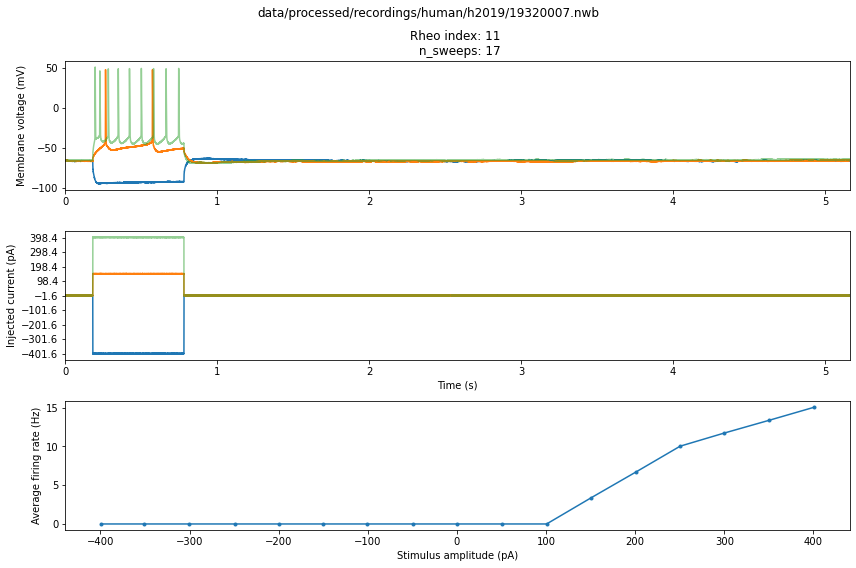

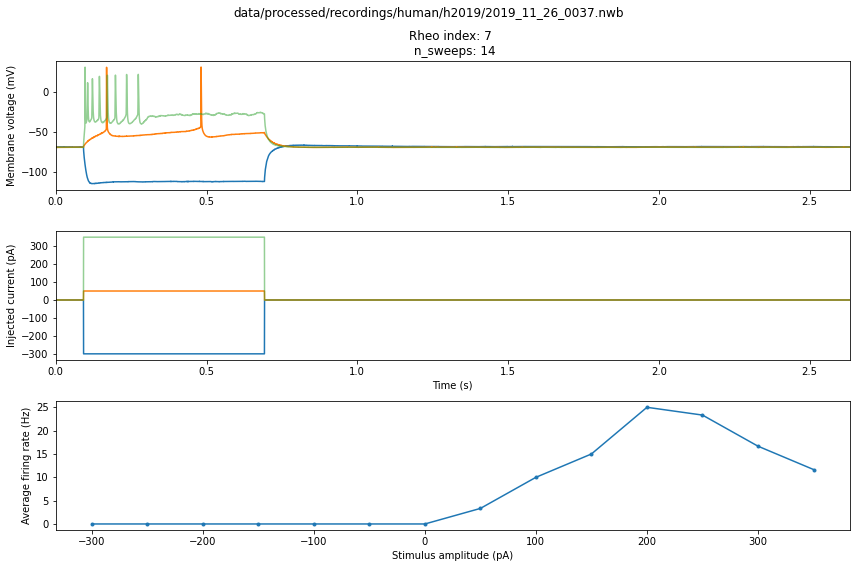

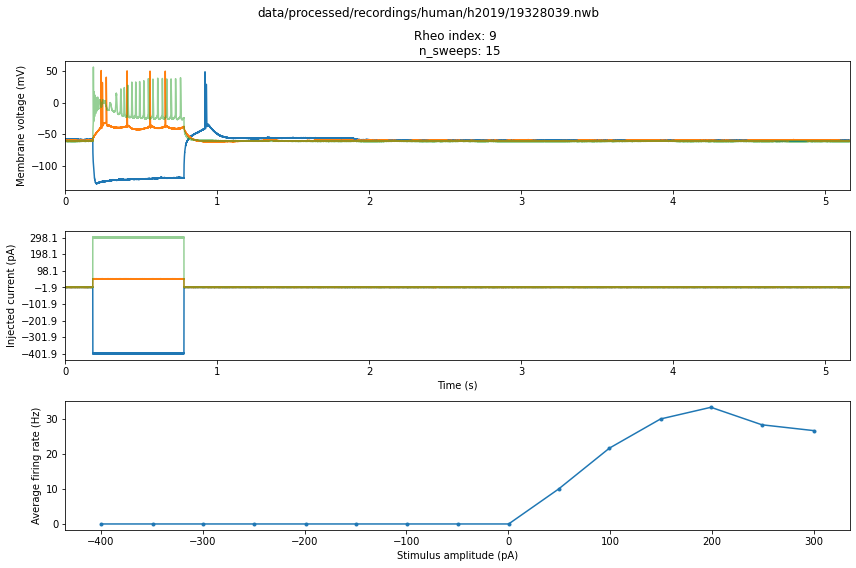

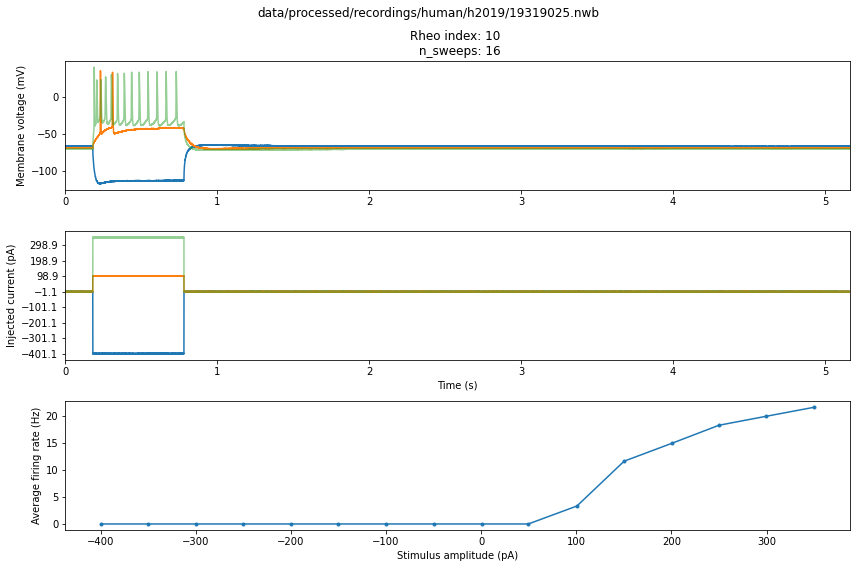

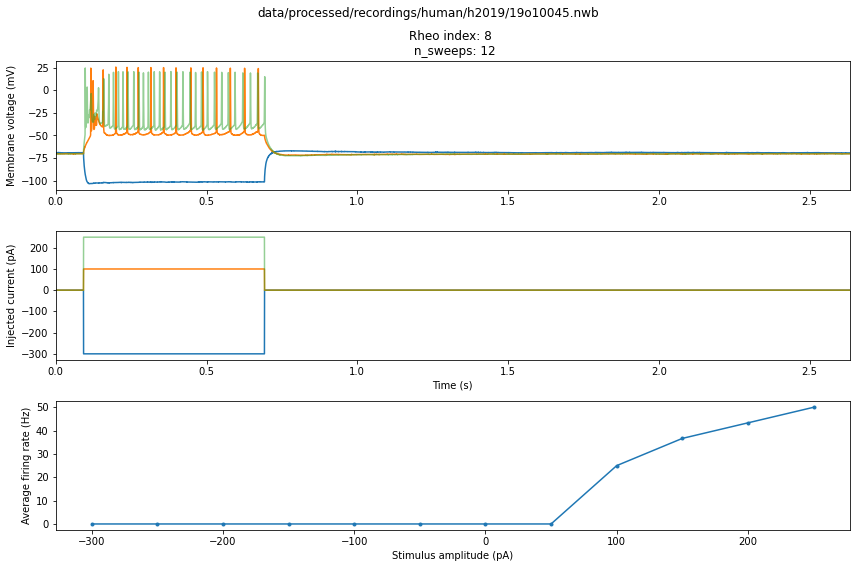

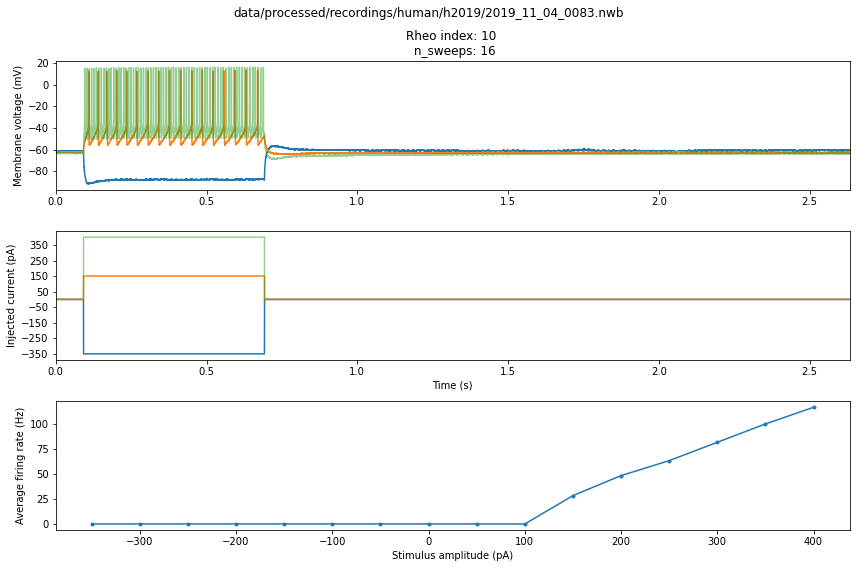

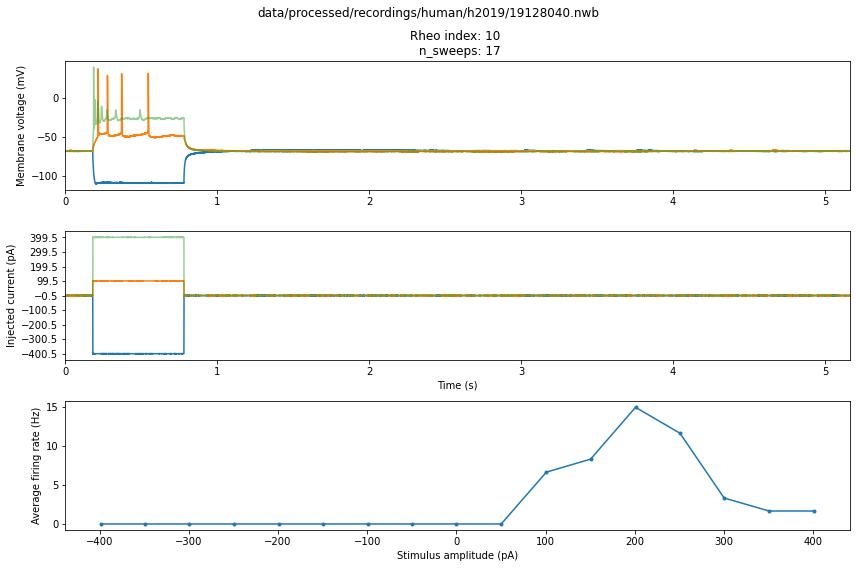

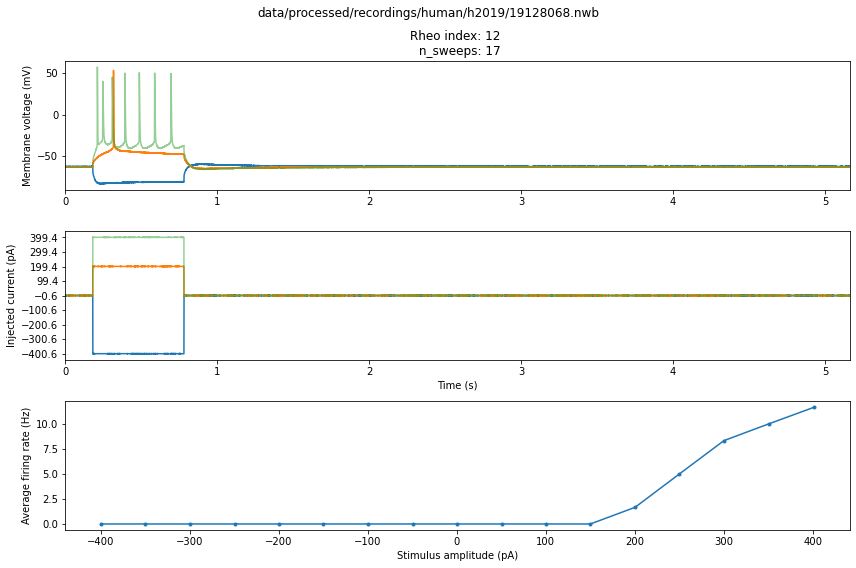

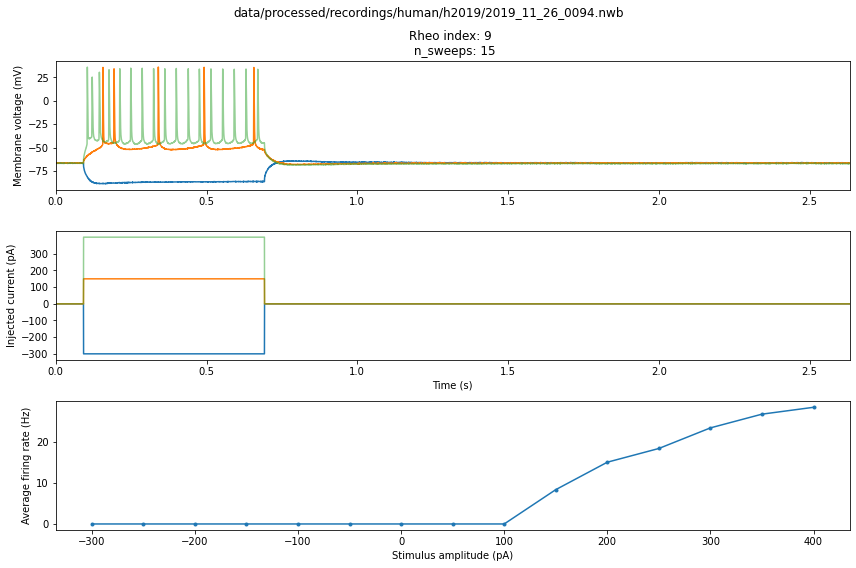

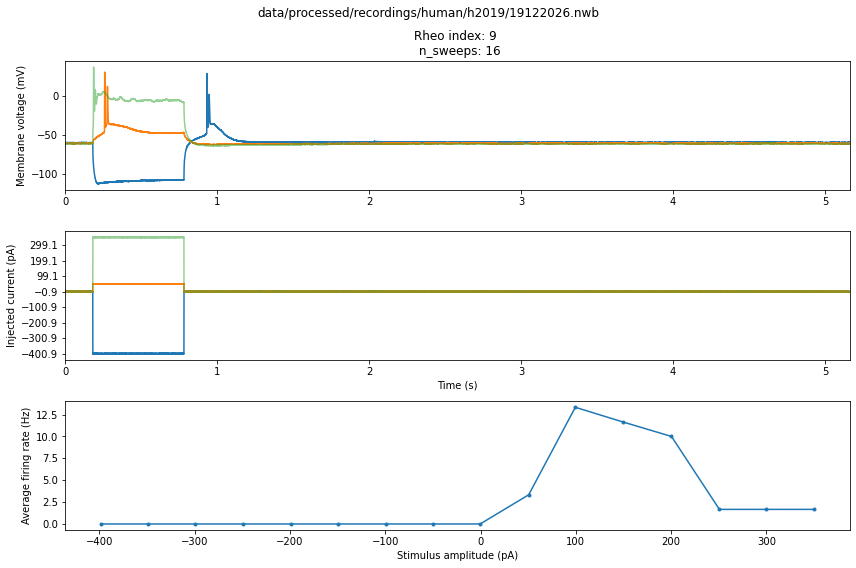

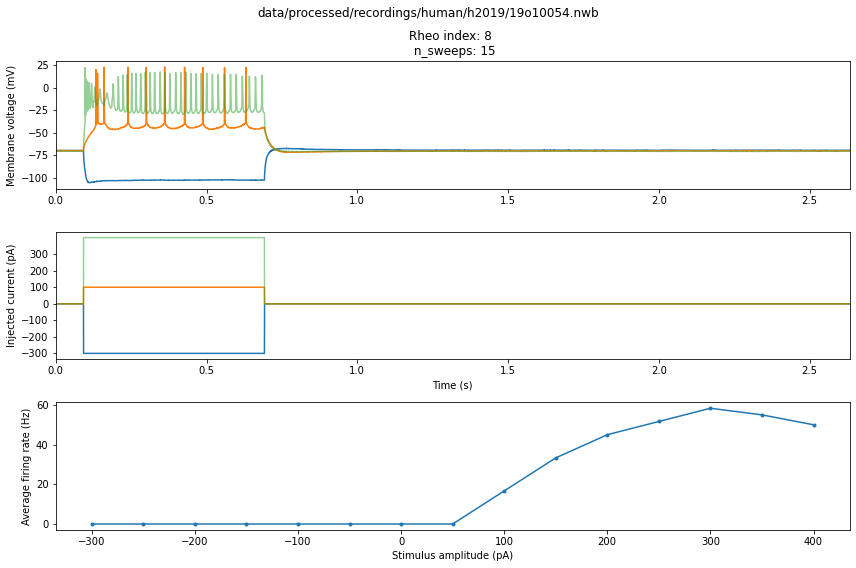

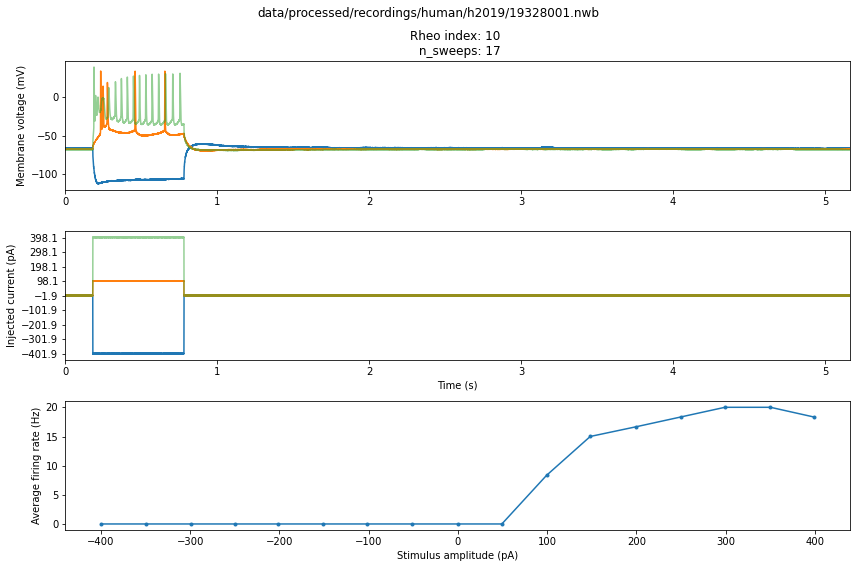

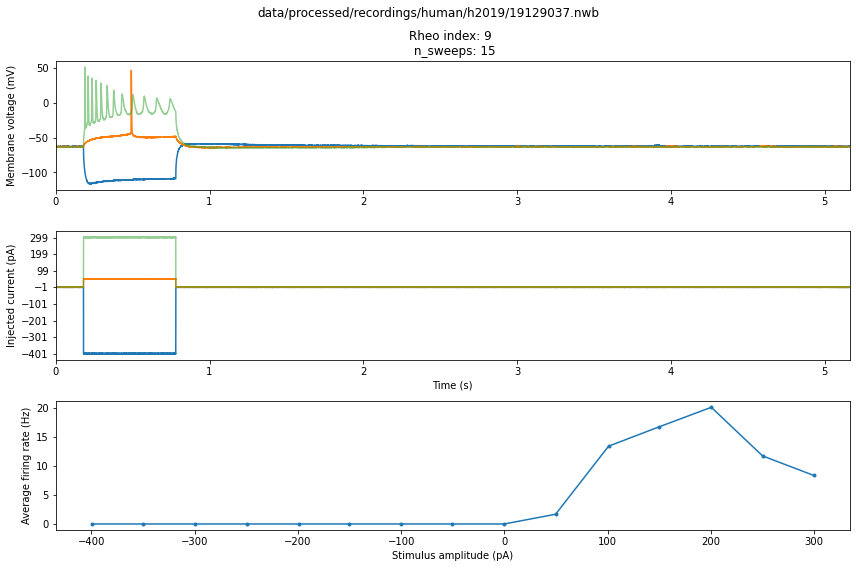

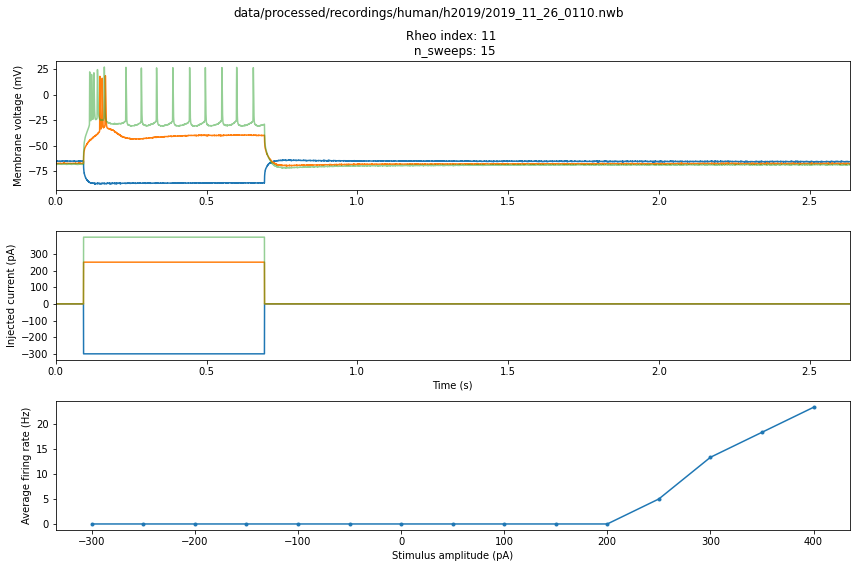

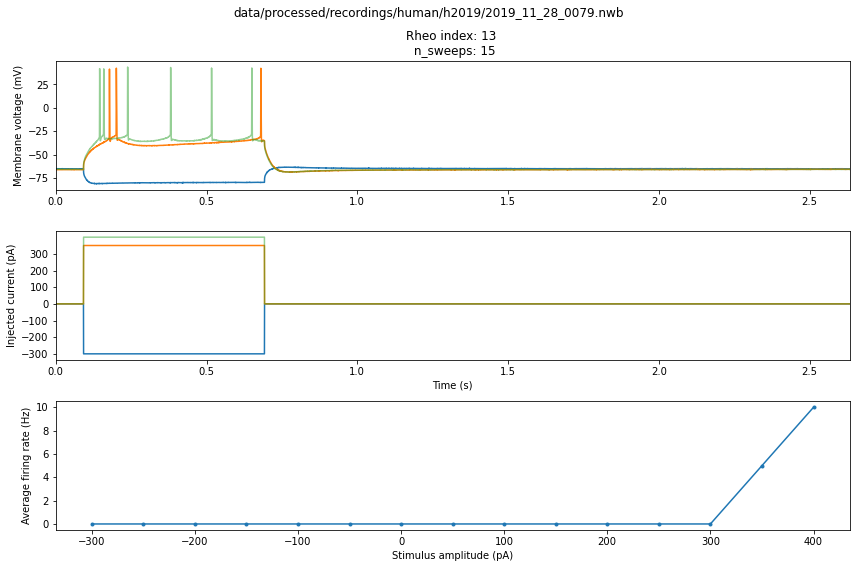

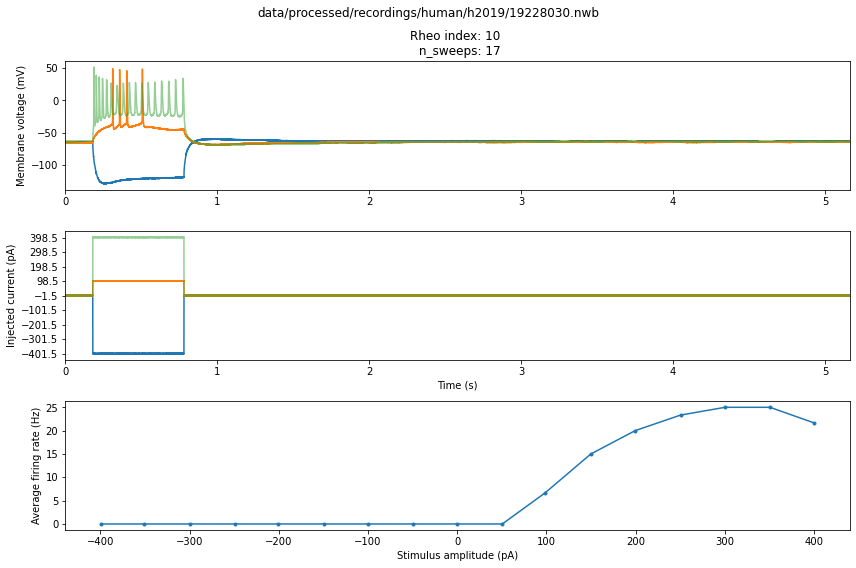

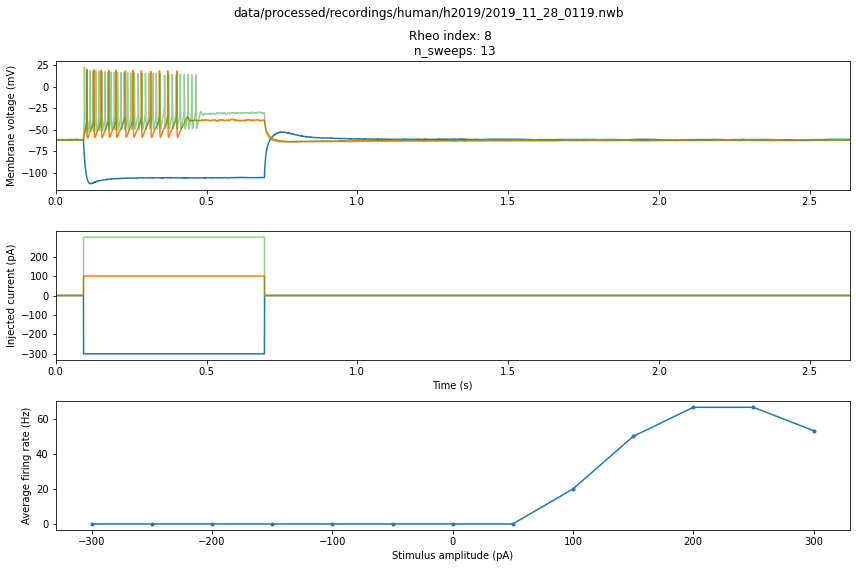

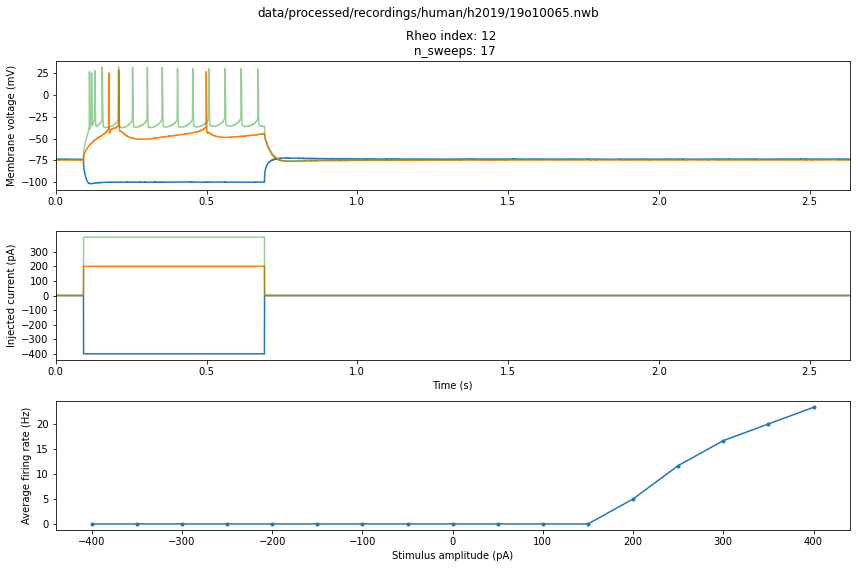

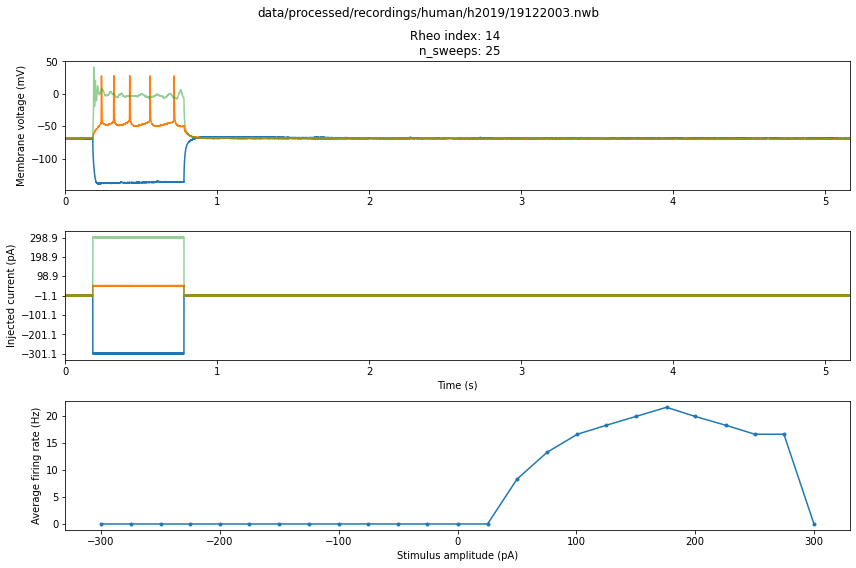

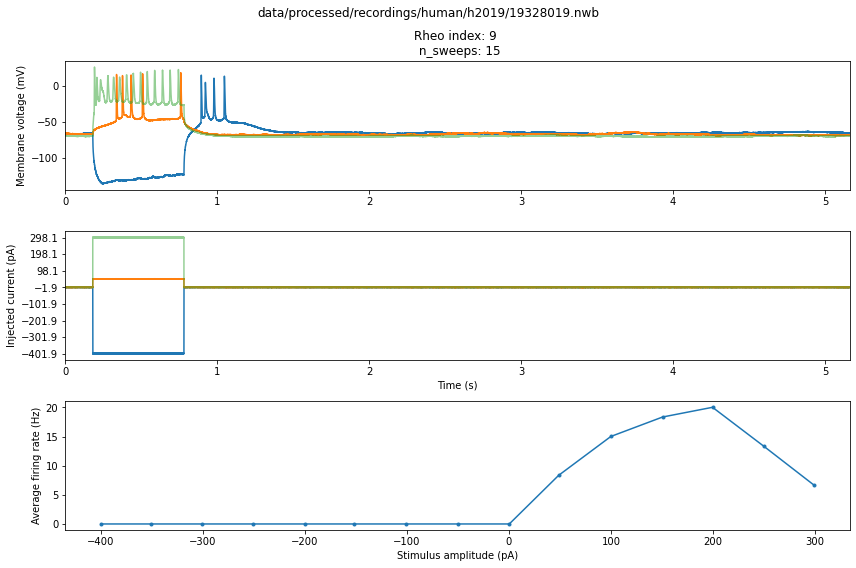

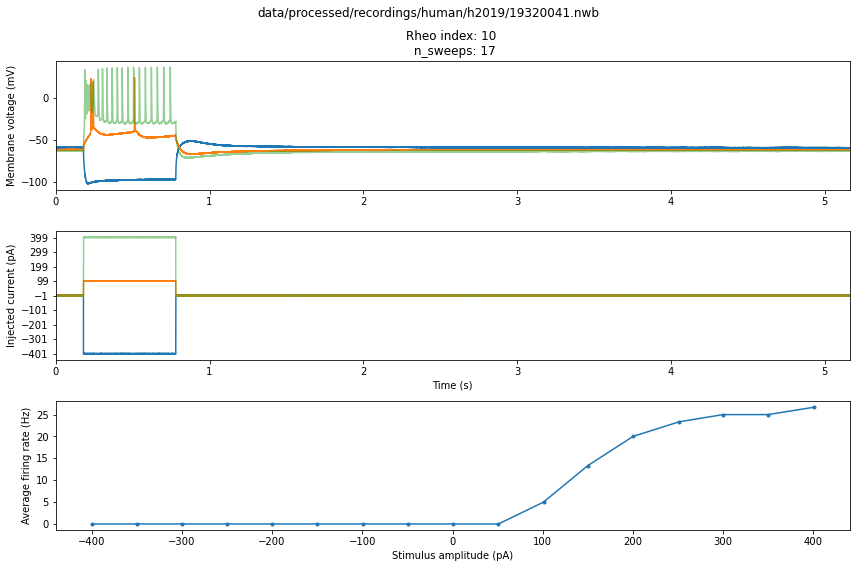

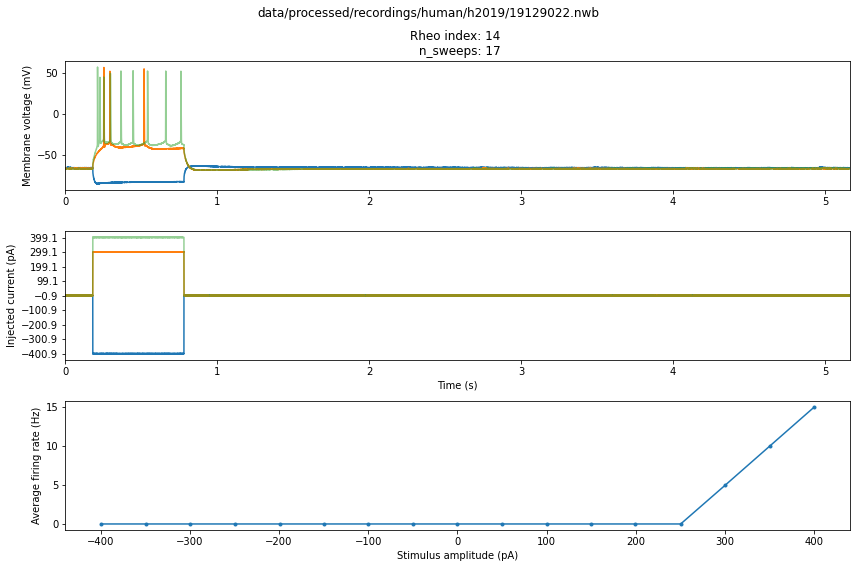

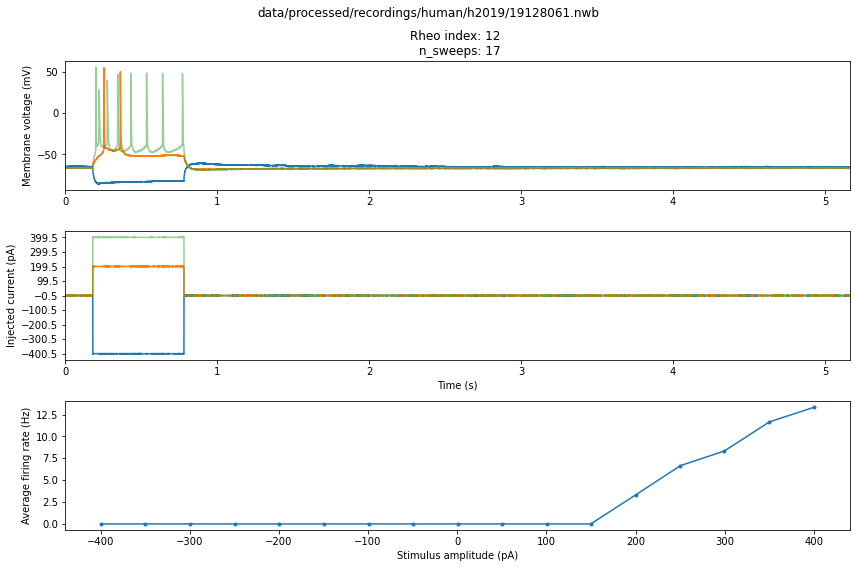

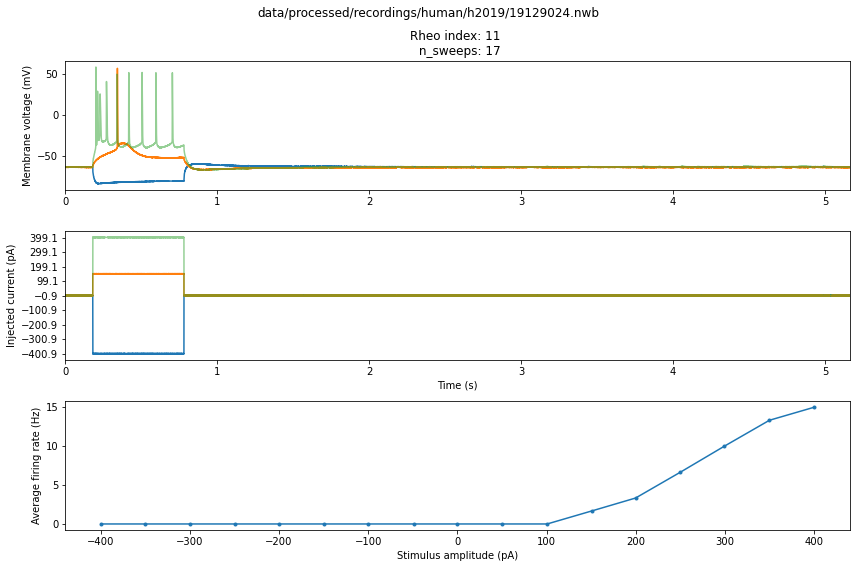

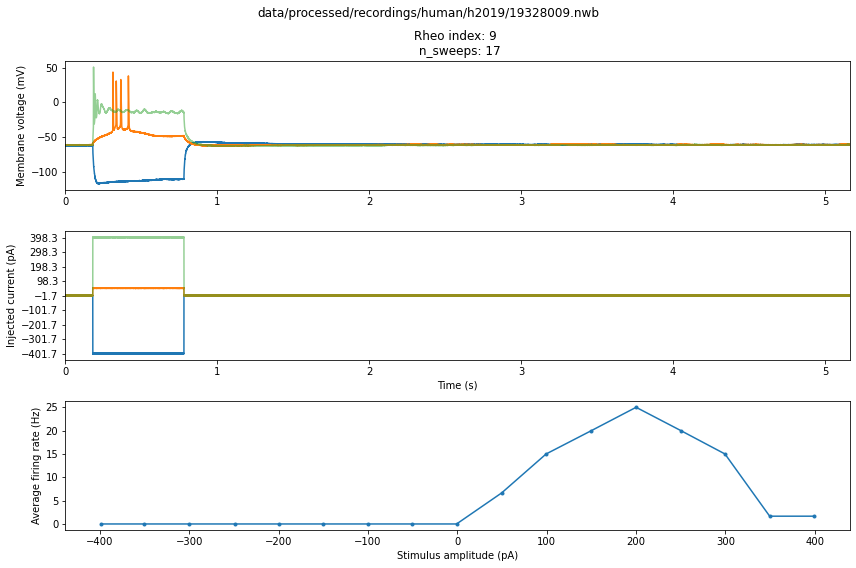

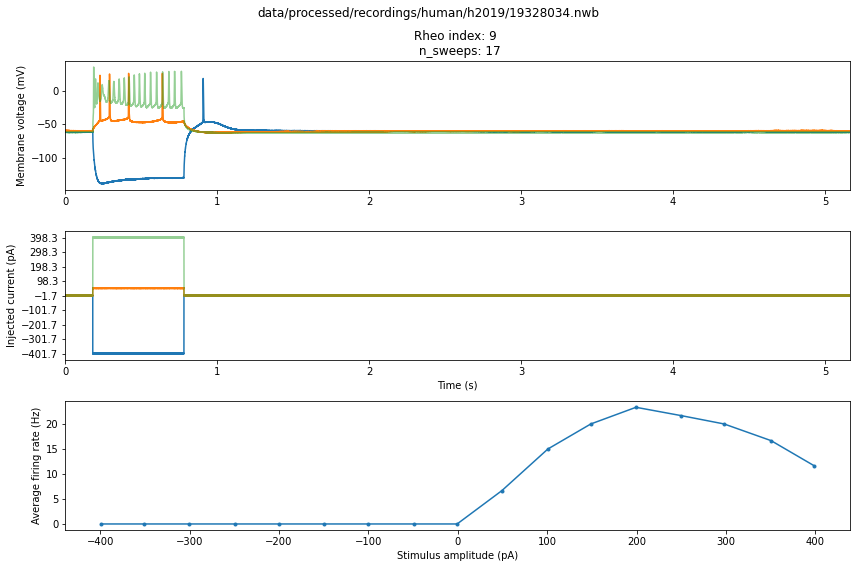

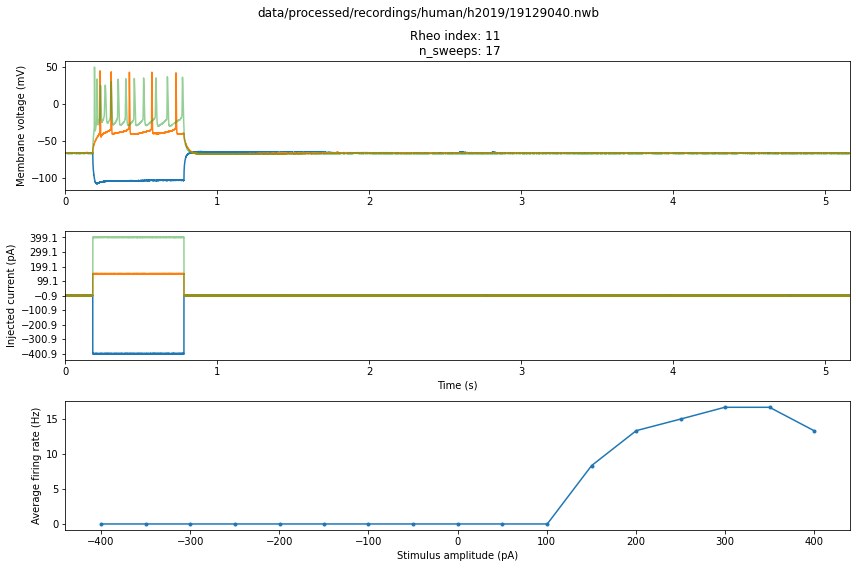

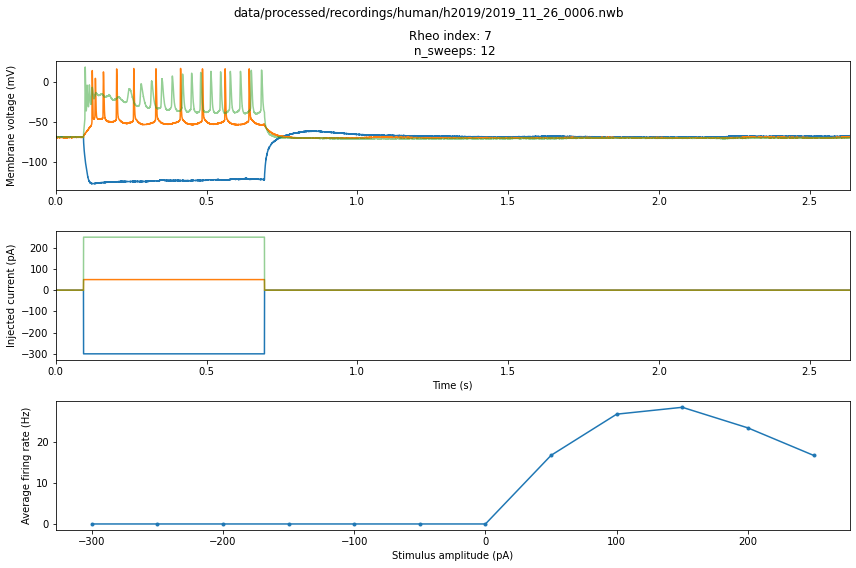

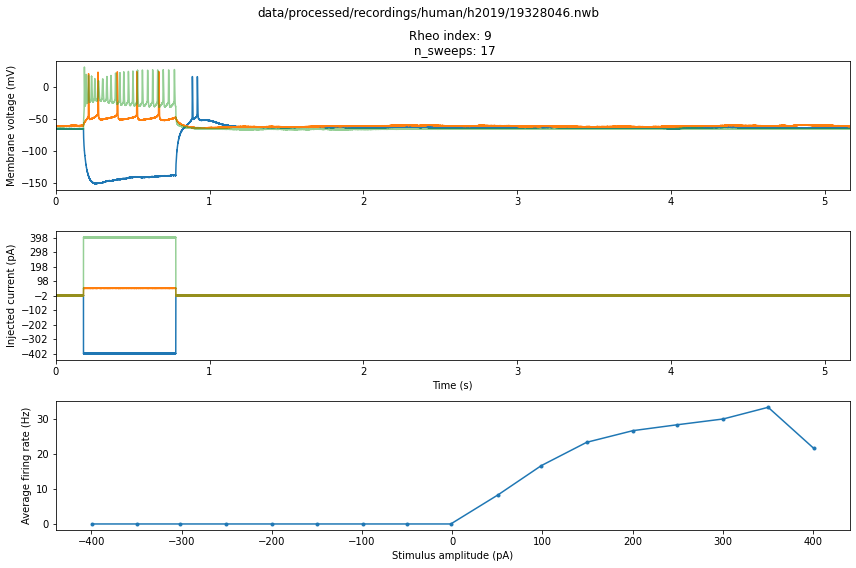

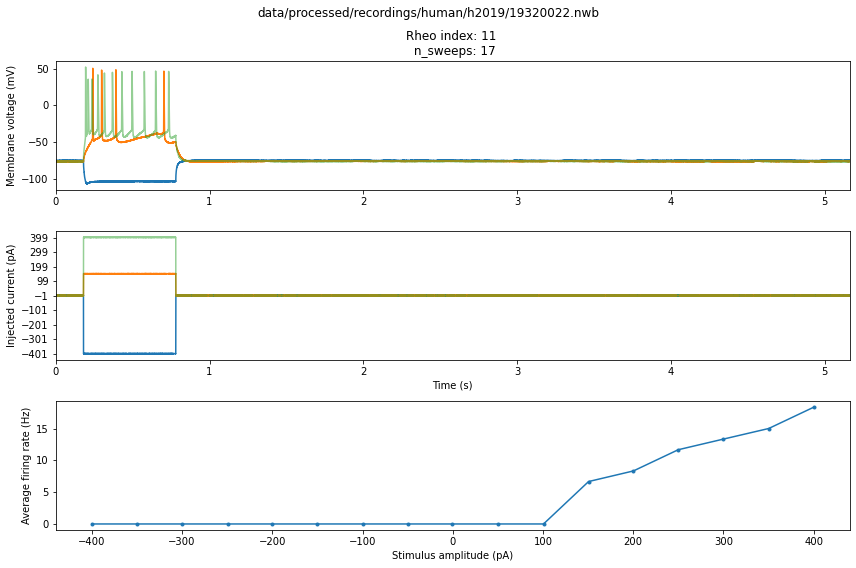

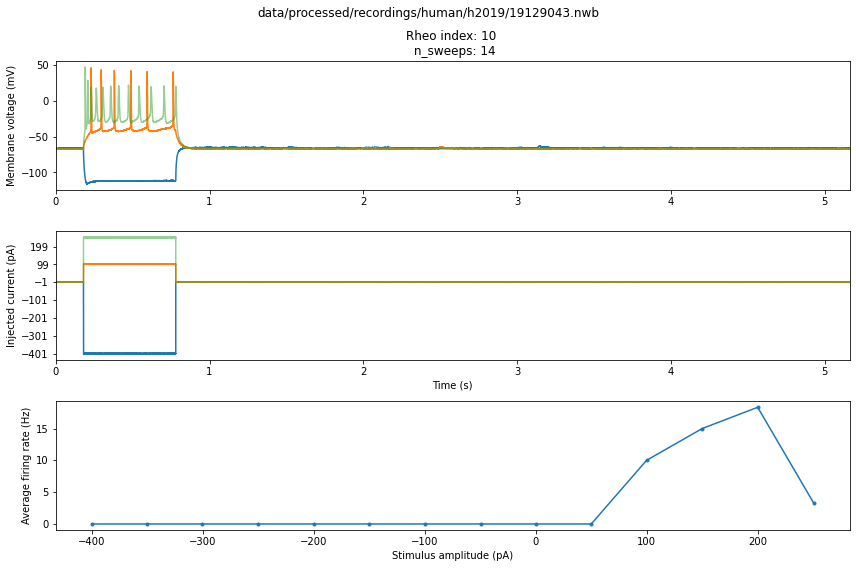

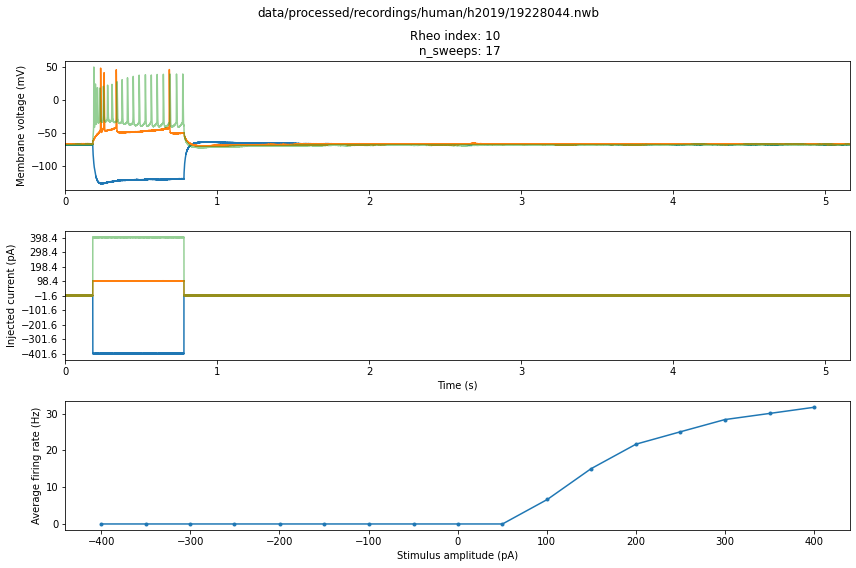

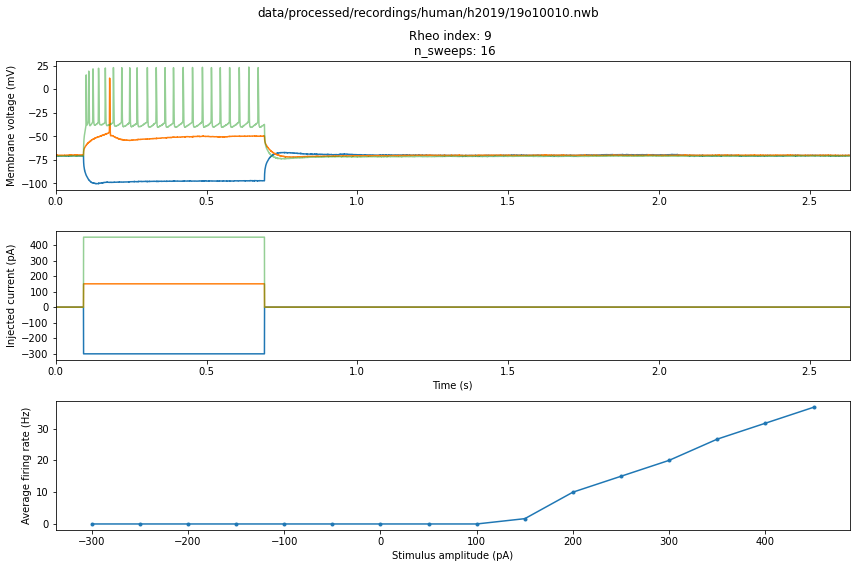

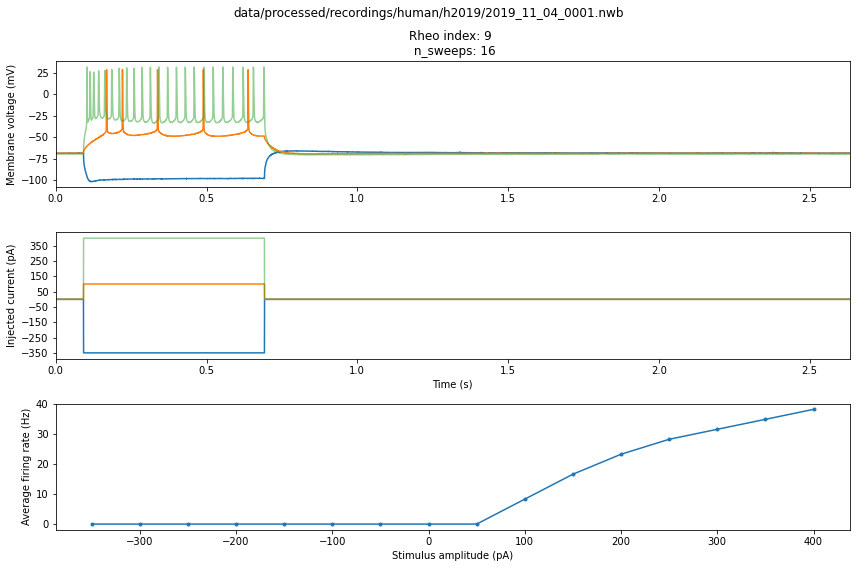

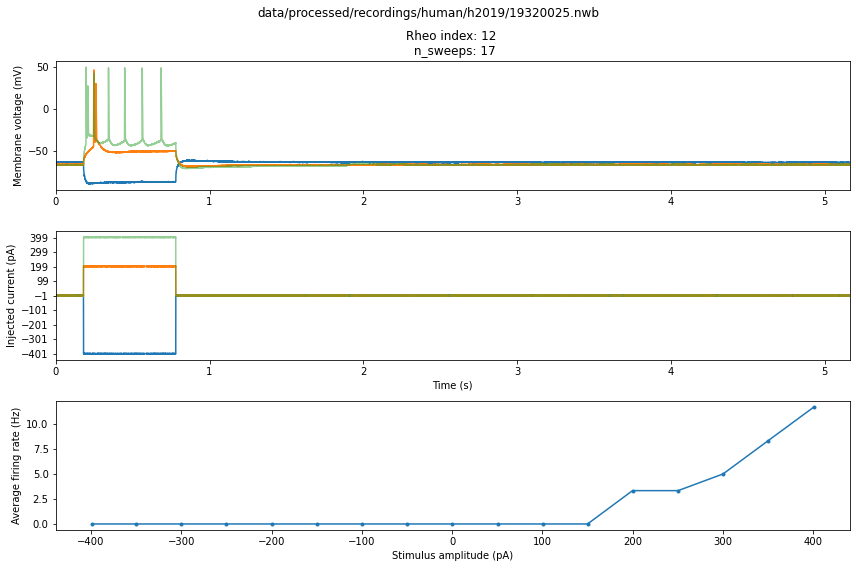

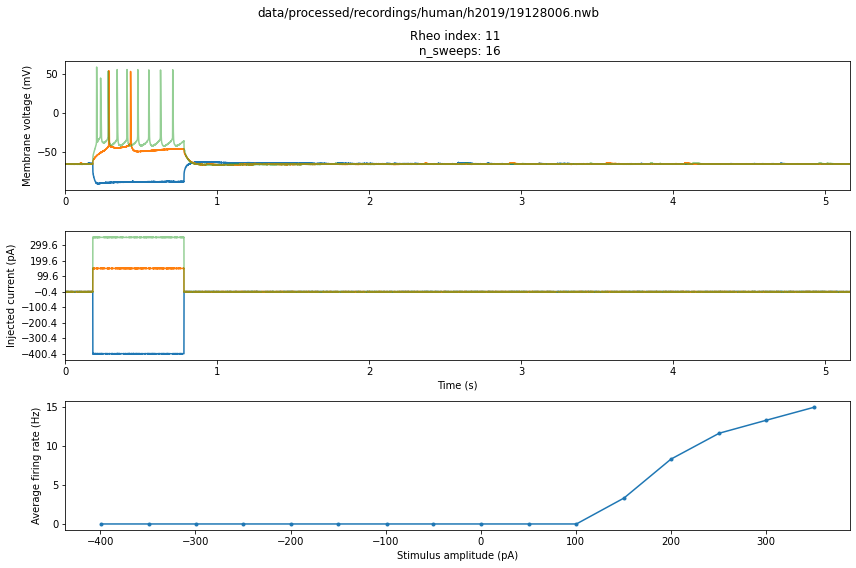

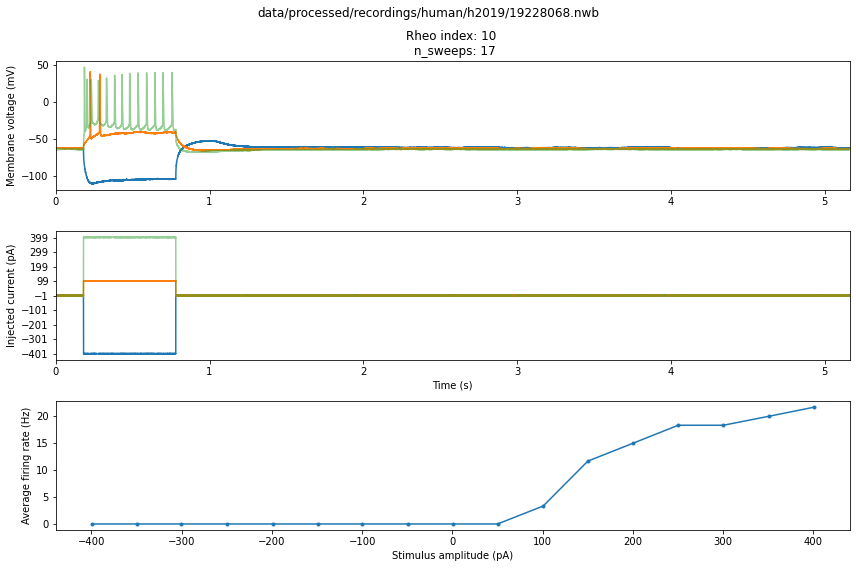

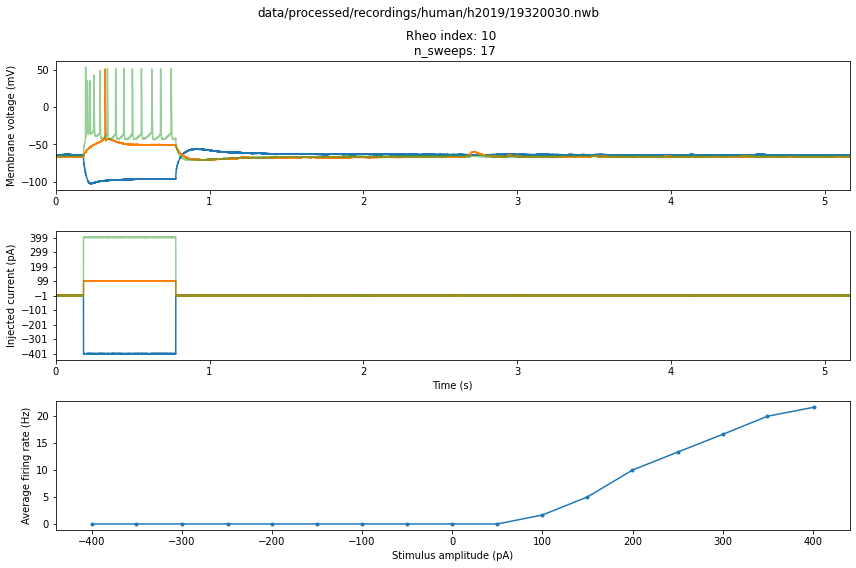

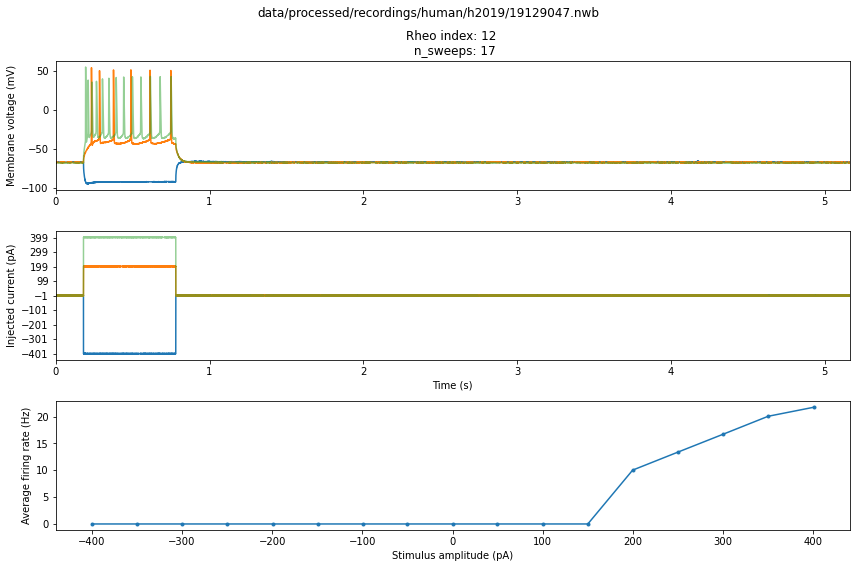

In [11]:
errors = []
# there are some duplicates in h19 from the natcom paper, skip them here
for i, row in h19[~h19.file_name.isin(natcom.file_name)].iterrows():
    try:
        #if row.
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, save_dir=h19_figs)
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
    #except FeatureError as e:
        print(f'Error: {e} \n') # {row.filename} \n')

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Co

INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:---

INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not 

INFO:root:Could not redetermine threshold-peak pair - dropping that pair
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/n

INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


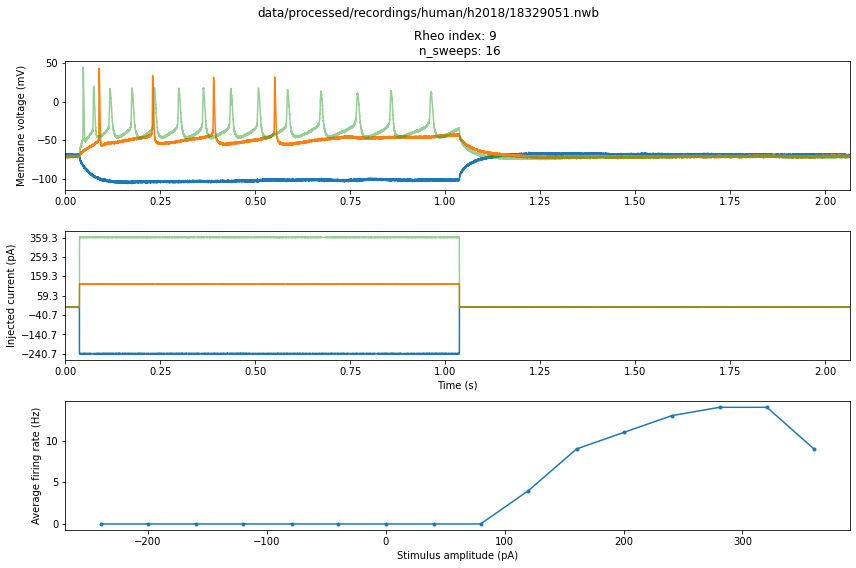

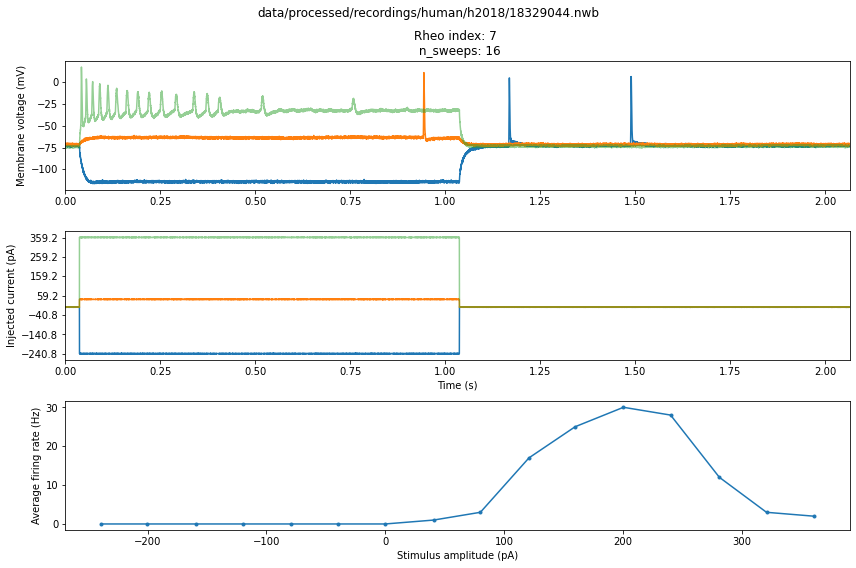

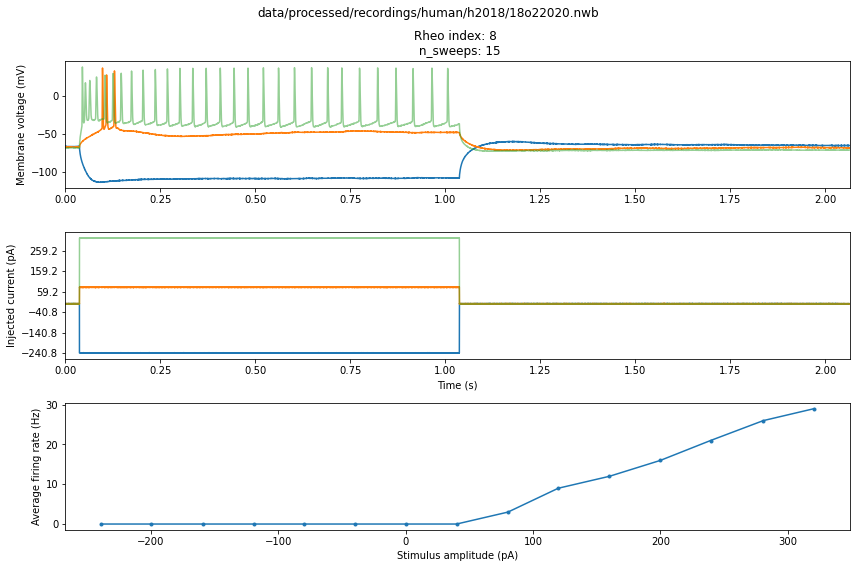

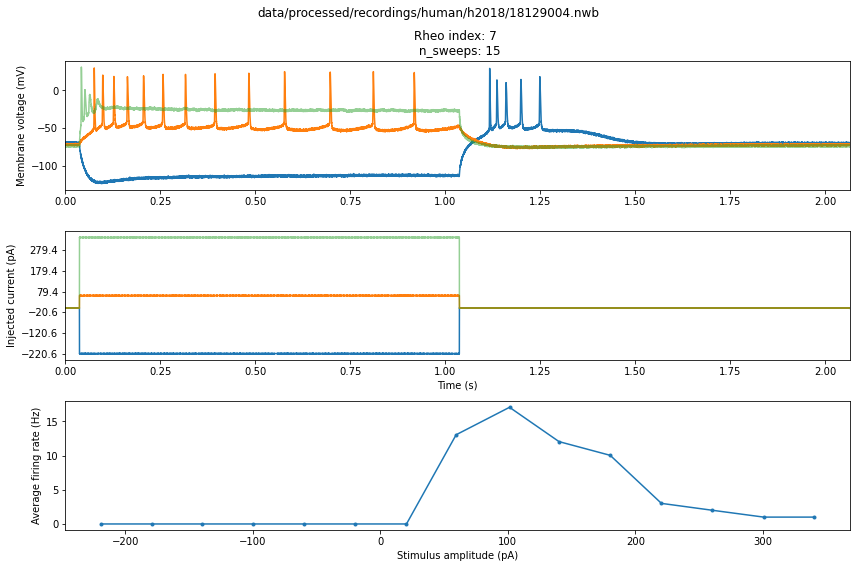

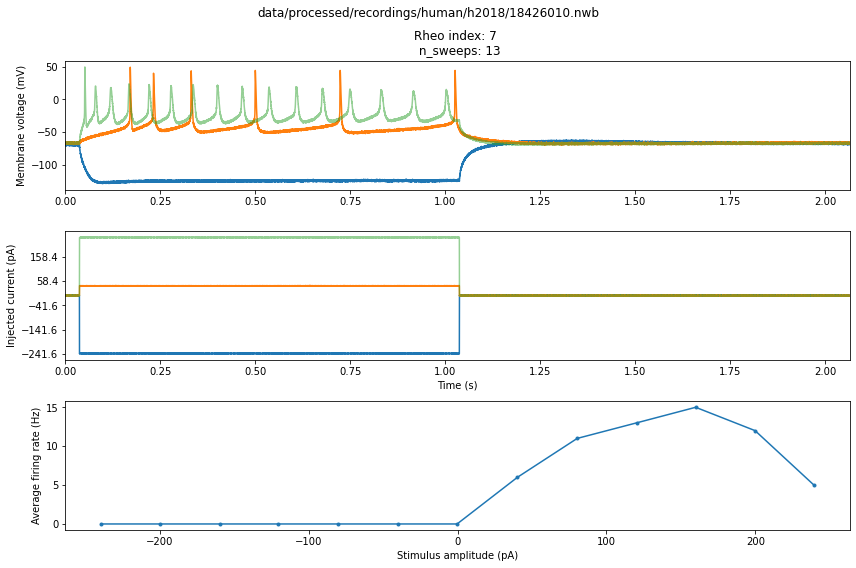

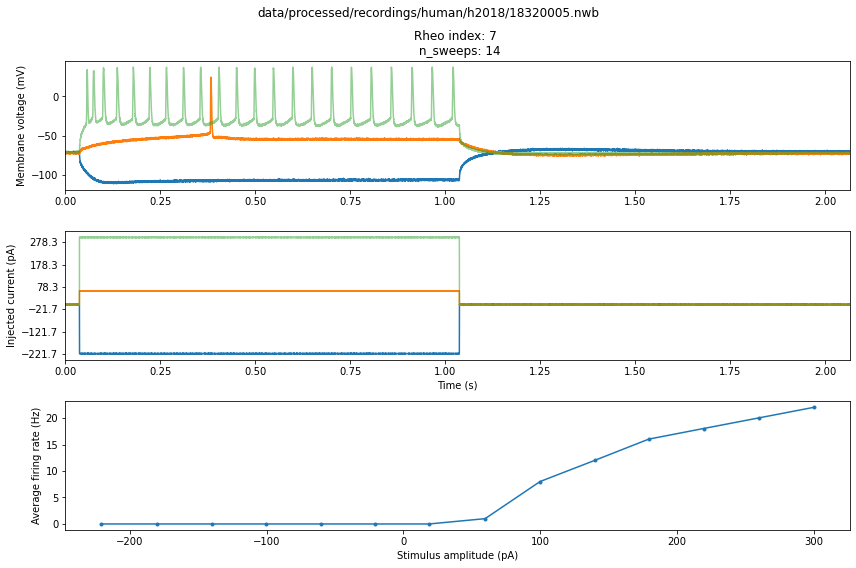

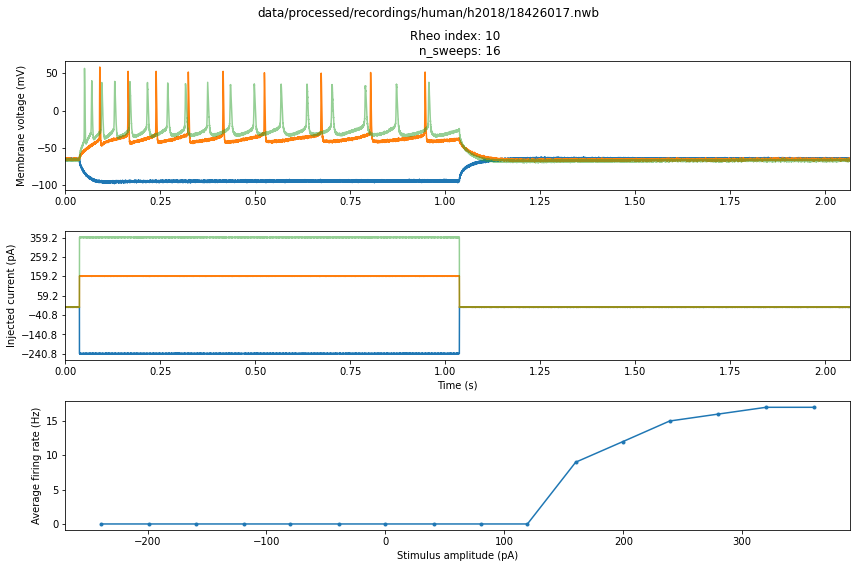

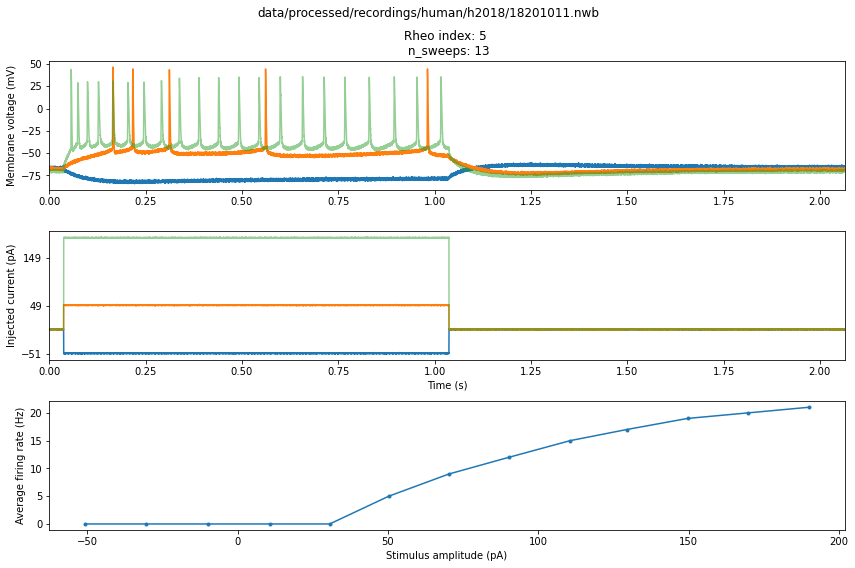

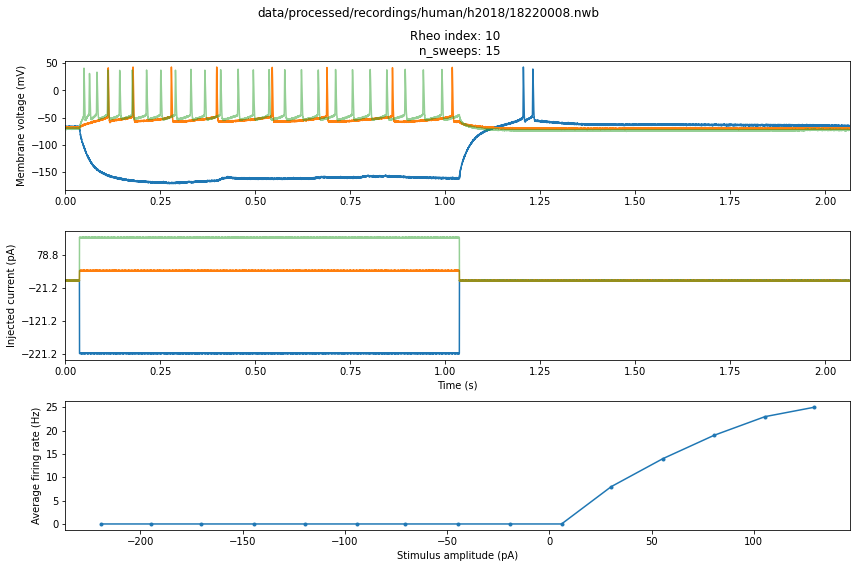

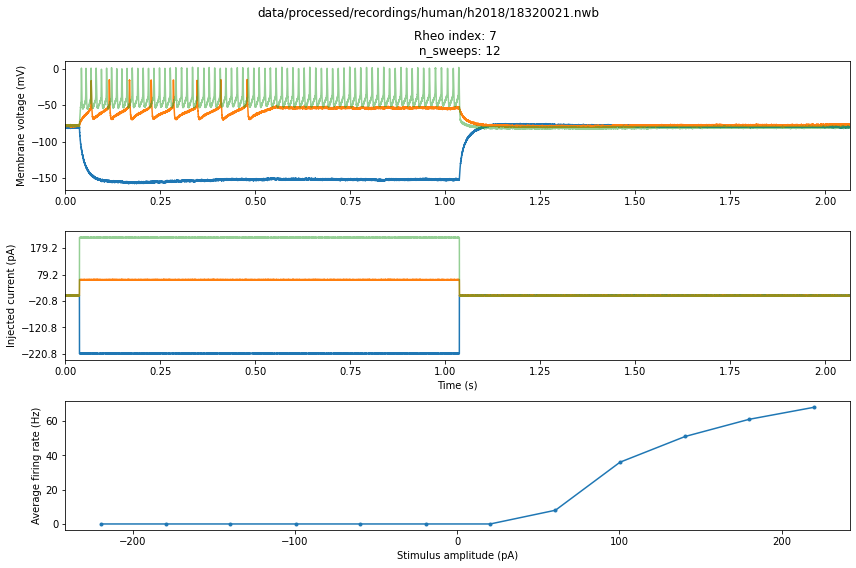

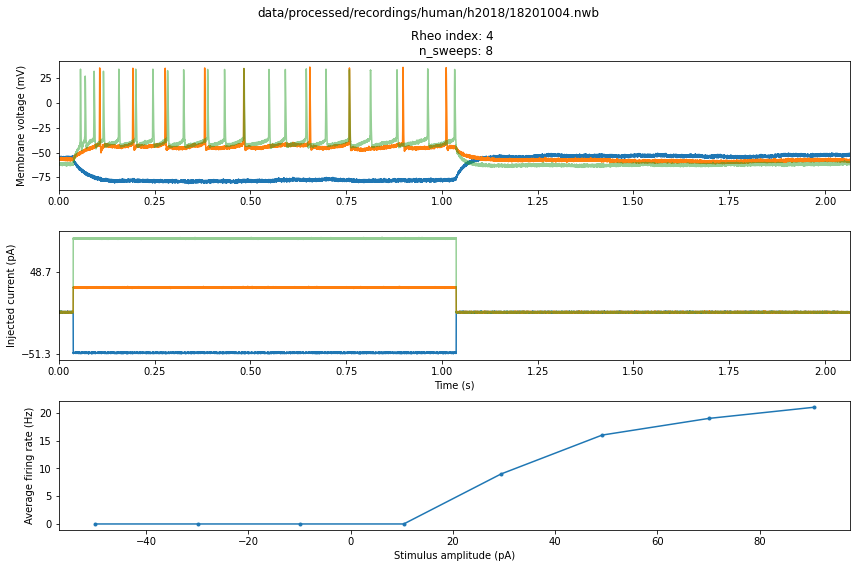

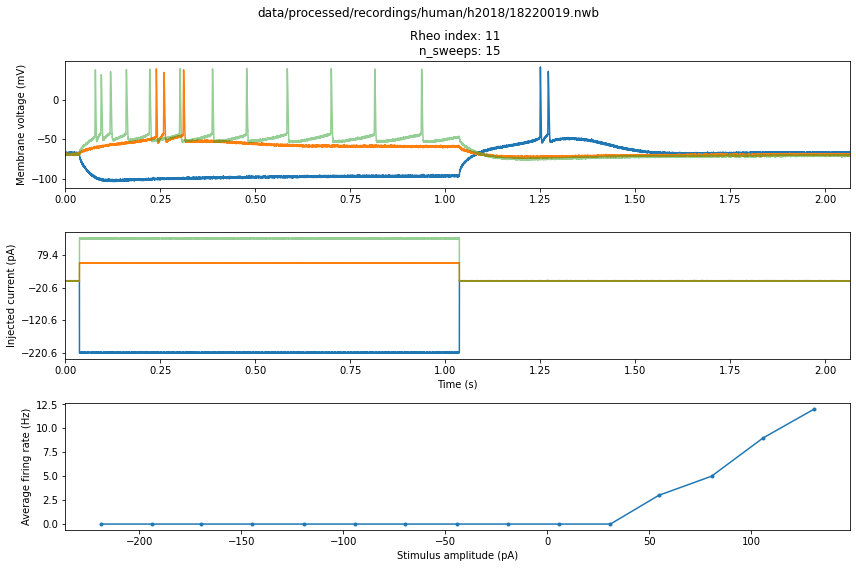

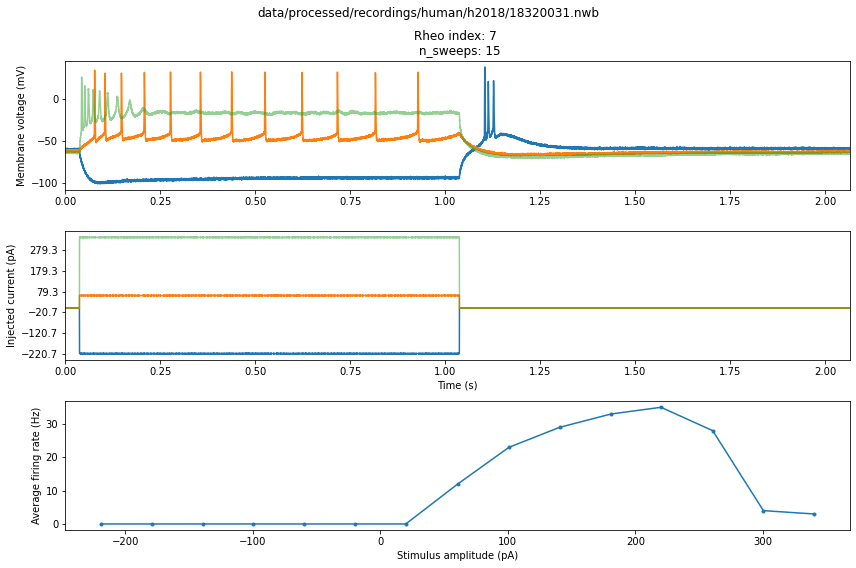

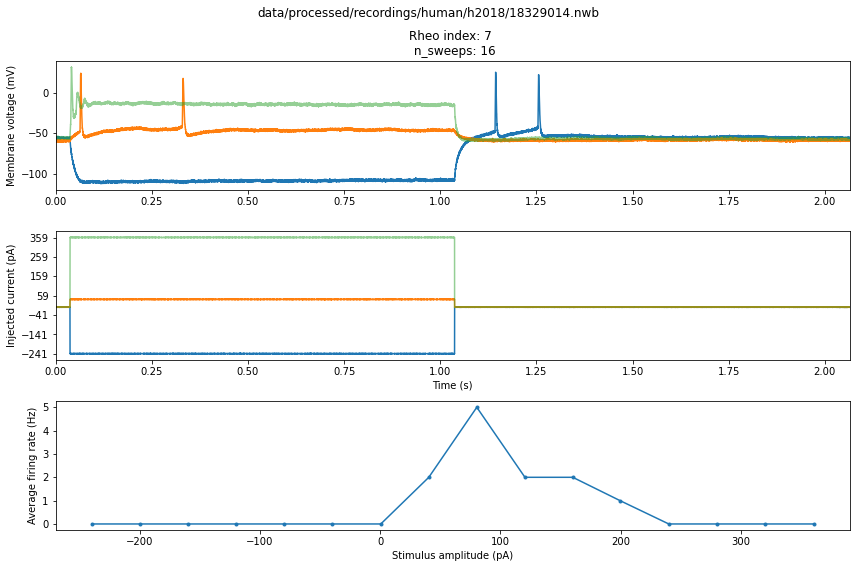

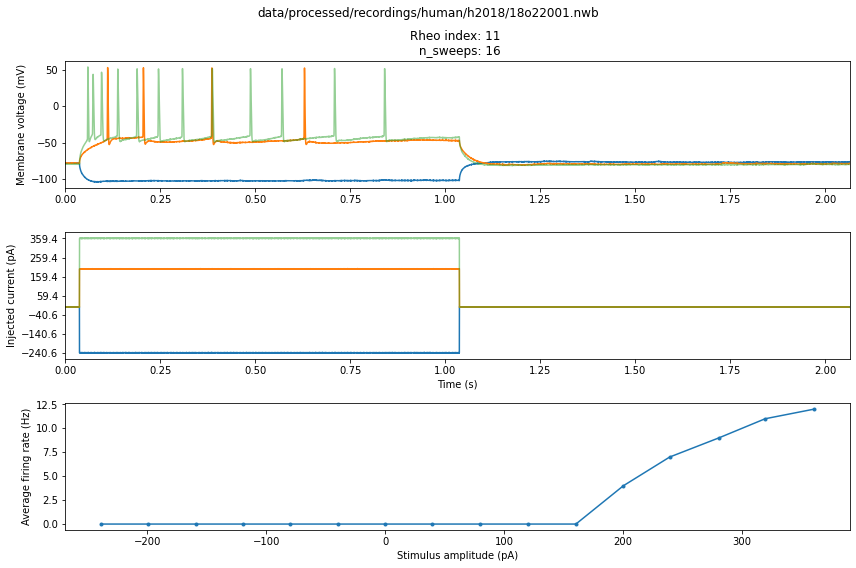

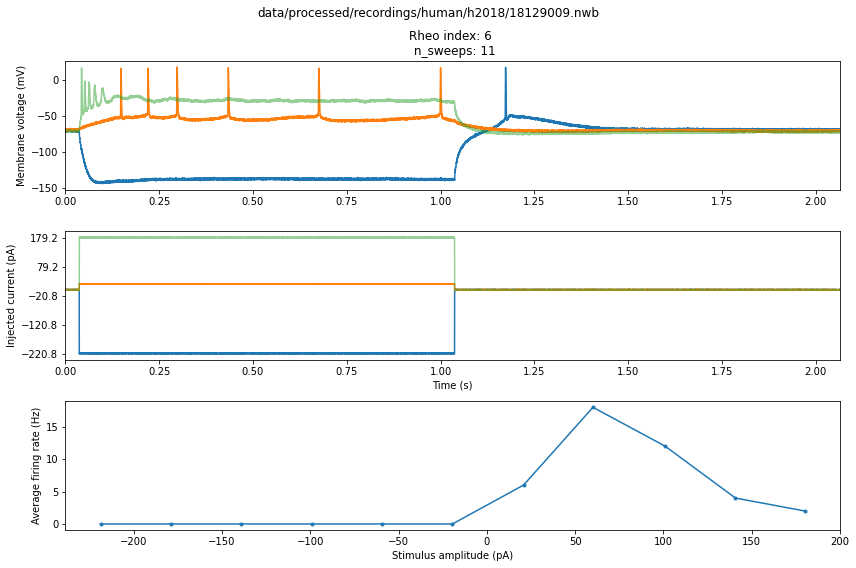

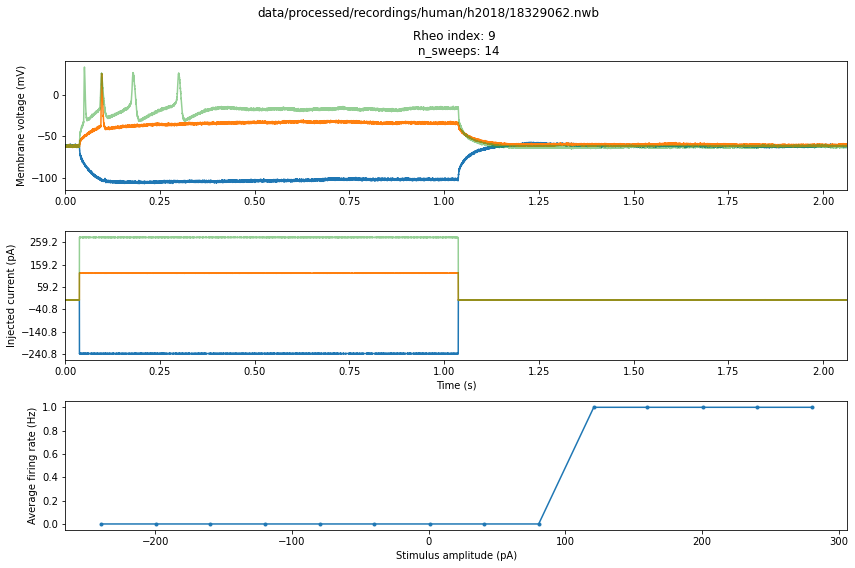

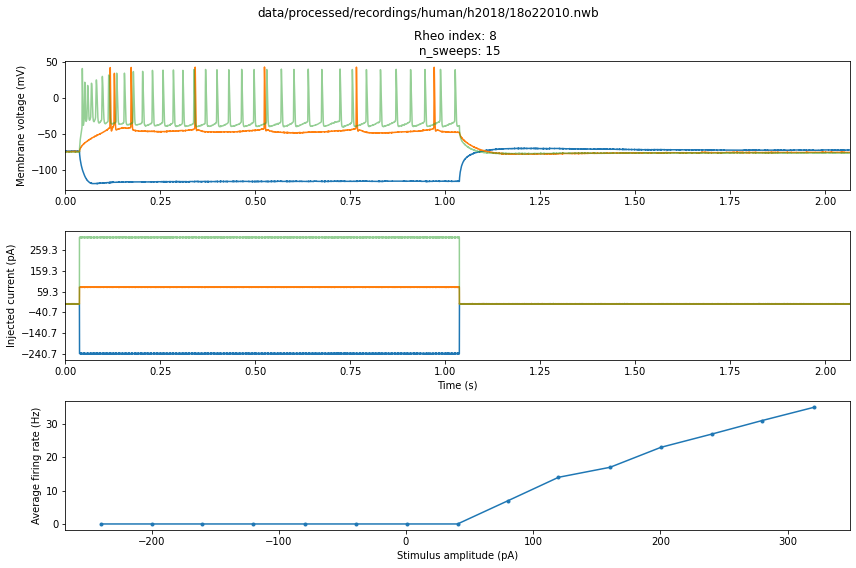

In [12]:
for i, row in h18.iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, save_dir=h18_figs)
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n')

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
IN

INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


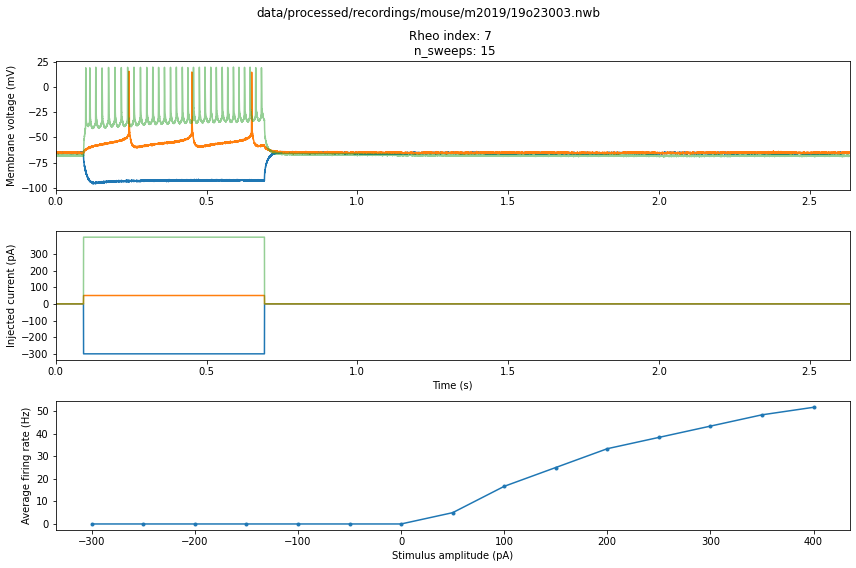

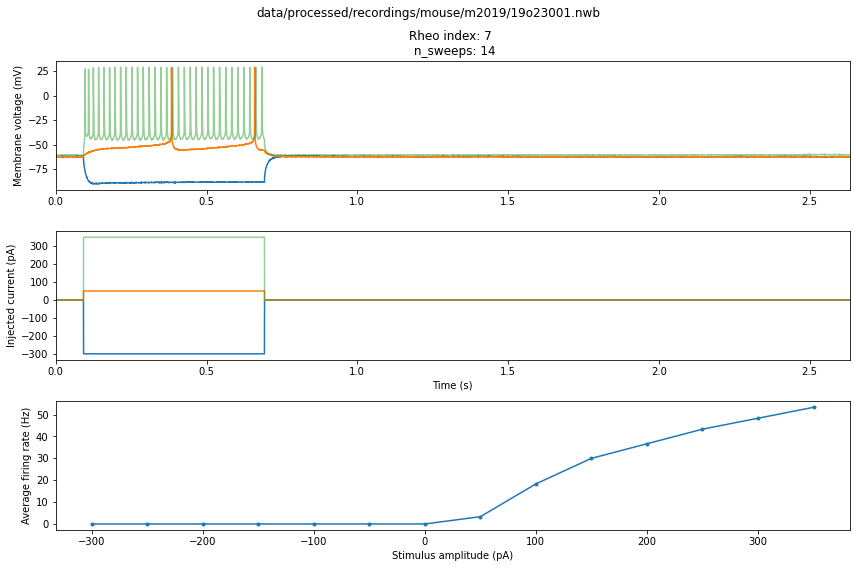

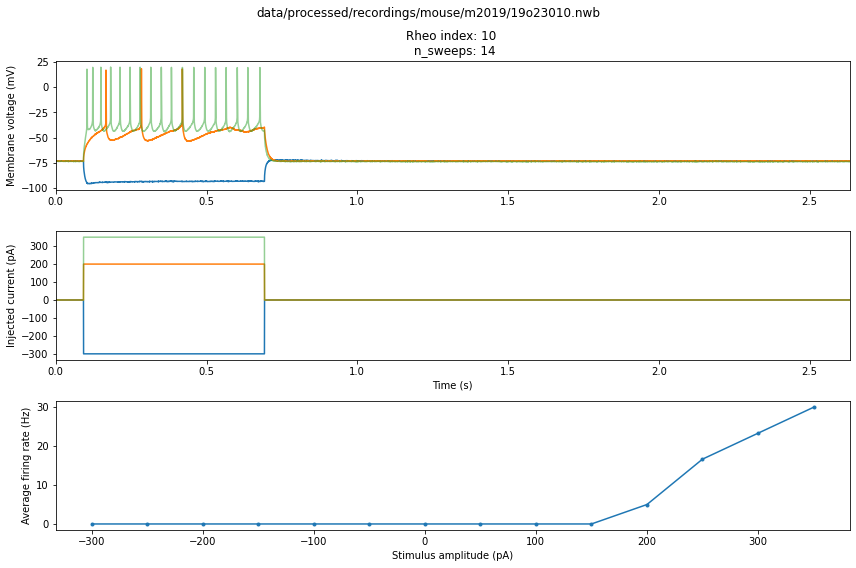

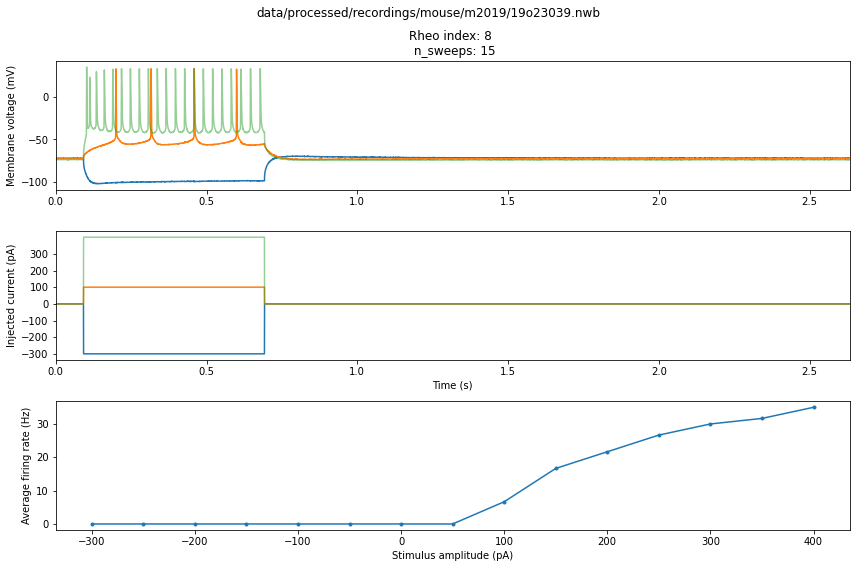

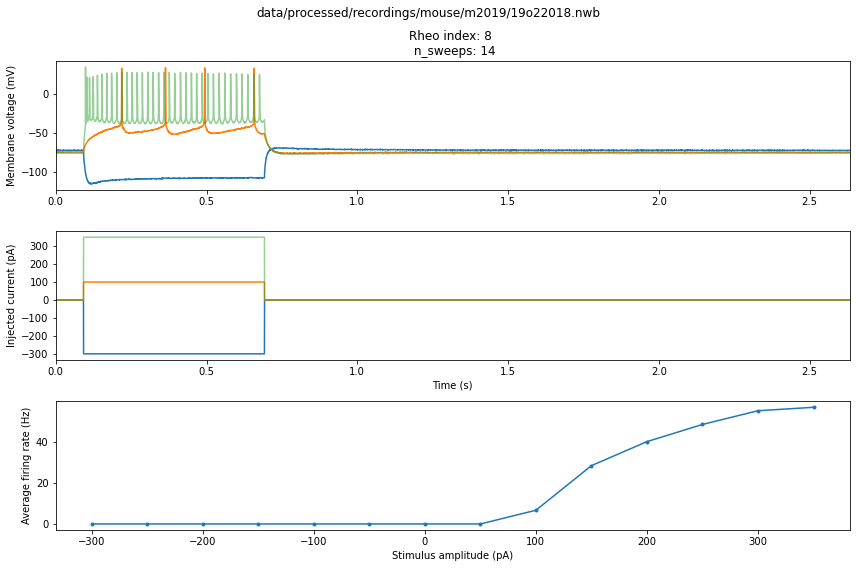

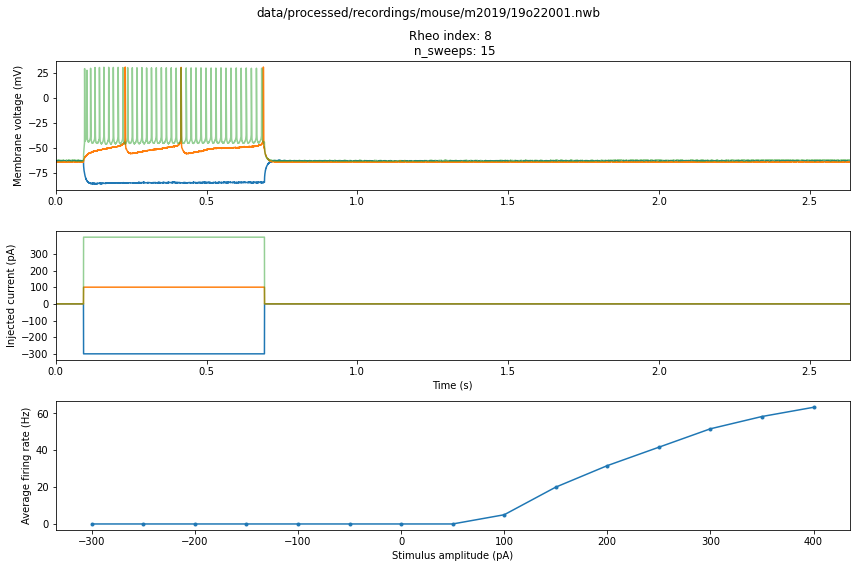

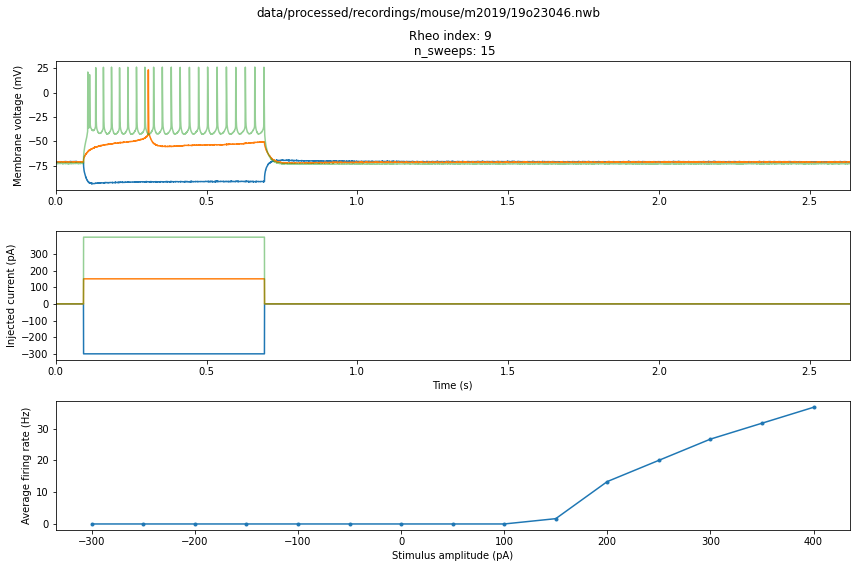

In [13]:
for i, row in m19.iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, save_dir=m19_figs)
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n')

INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak

INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that 

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus_protocol_analysis.py:219: RuntimeWarning: Mean of empty slice
  features["tau"] = np.nanmean(calc_subthresh_features['tau'])
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


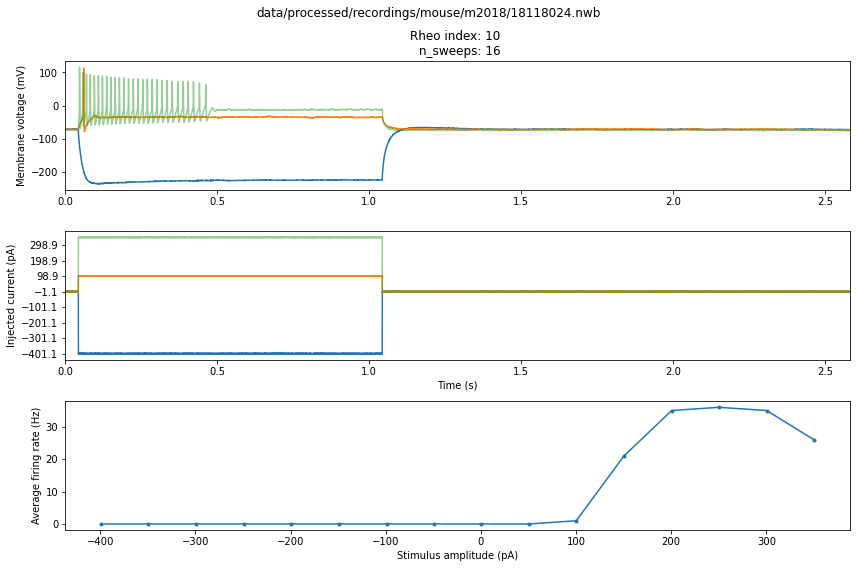

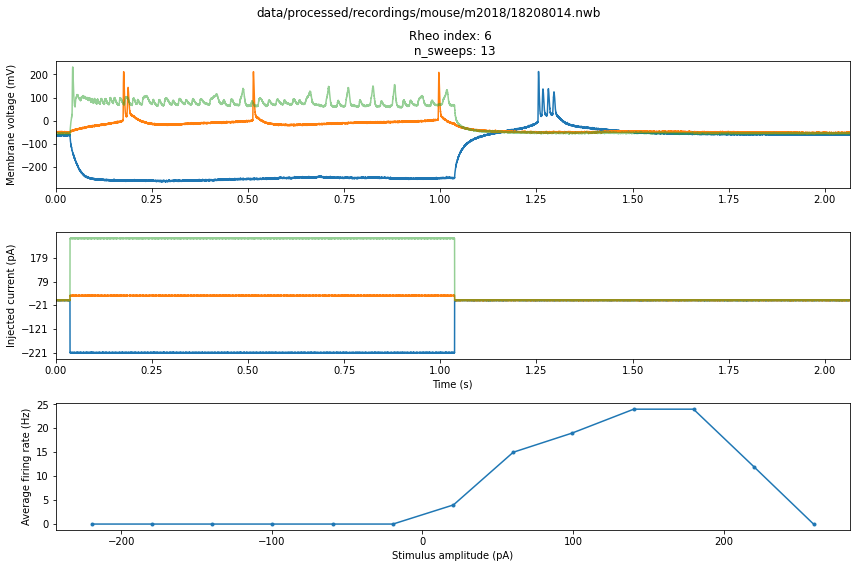

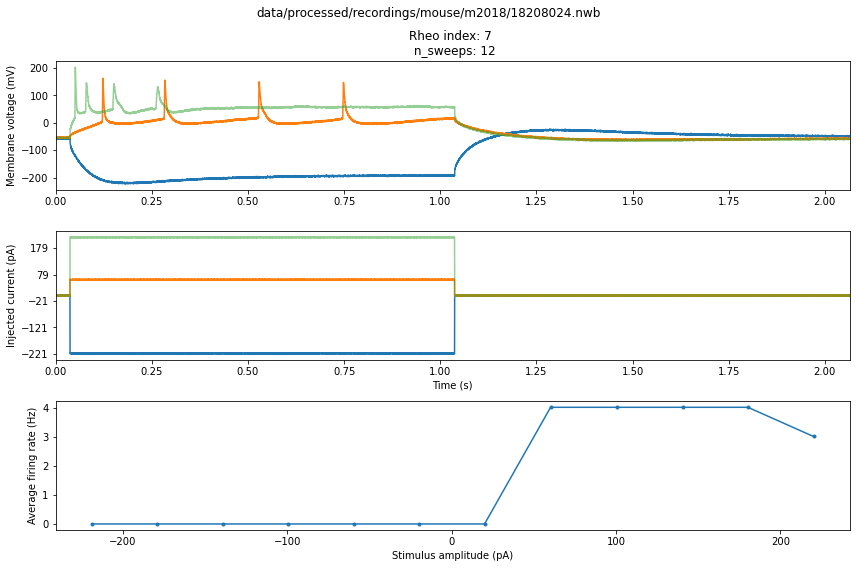

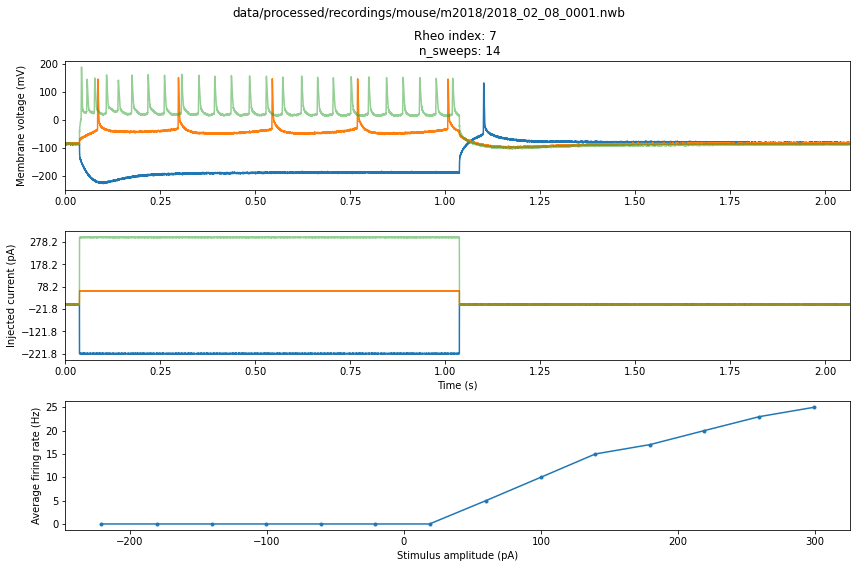

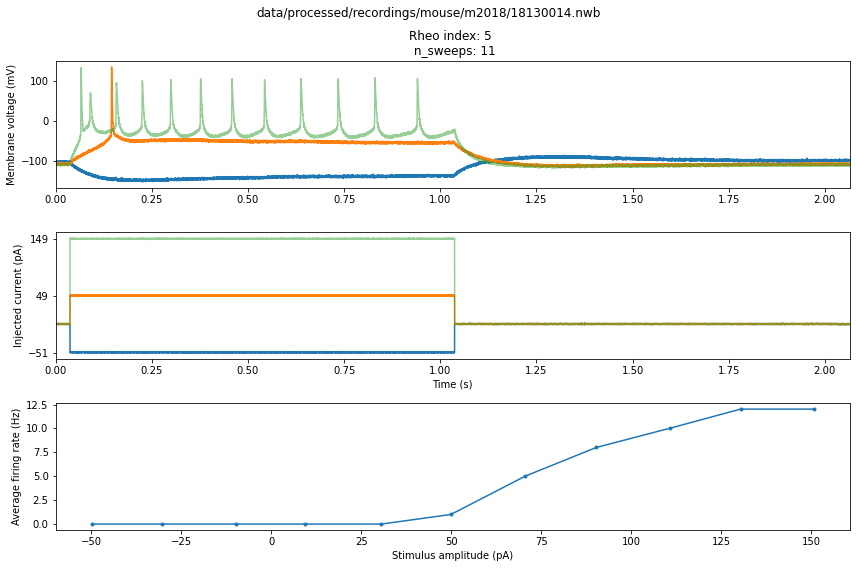

In [14]:
for i, row in m18.iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, baseline_interval=0.0001, save_dir=m18_figs)
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n')

In [15]:
errors = []
for i, row in natcom.iterrows():
    try:
        plot_nwb_QC(nwb_path=row.path, ontology=ontology_path, stim_start_time=row.stim_start_time, stim_end_time=row.stim_end_time, save_dir=natcom_figs)
    except (AssertionError, AttributeError, TypeError, FeatureError, ValueError) as e:
        print(f'Error: {e} \n') 